In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr, spearmanr
import matplotlib.dates as mdates
import datetime as dt
# plt.rcParams["figure.figsize"] = (15,10)
plt.style.use('../images/presentation.mplstyle')

In [2]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
def get_percentage_people_per_age_group(people_per_age, ages):
    n_total = people_per_age.num_people.sum()
    percentage_per_age = {}
    for a in ages:
        n_people = people_per_age[(people_per_age.age>=a[0]) & (people_per_age.age<=a[1])].num_people.sum()
        percentage = 100 * n_people/n_total
        percentage_per_age[a] = percentage
    return percentage_per_age

In [5]:
people_per_age = pd.read_csv("num_people_per_age.csv")

In [6]:
geo_stats = pd.read_csv("geographic-sum-per-day-ver_00213.csv")
geo_stats_2 = pd.read_csv("corona_city_table_ver_0085.csv")
geo_vacc_per_age = pd.read_csv("vaccinated_city_table_ver_0040.csv")


recover_data = pd.read_excel("corona_recovered_ver_00120.xlsx")
hospital_data = pd.read_csv("corona_hospitalization_ver_00249.csv")
dead_data = pd.read_csv("corona_deceased_ver_00105.csv")

age_gender_test_data = pd.read_csv("corona_age_and_gender_ver_00101.csv")
young_test_data = pd.read_excel("young_population_weekly_ver_0043.xlsx")

In [7]:
israel_population = pd.read_excel("israel_population_by_city.xlsx")
israel_population_with_ages = pd.read_excel("israel_total_population_by_age.xlsx")
israel_english_names = pd.read_excel("israel_town_code_name_english.xlsx")

## organize geographic data 

In [9]:
geo_stats = pd.read_csv("geographic-sum-per-day-ver_00213.csv")
geo_stats['date'] = pd.to_datetime(geo_stats['date'],format='%Y-%m-%d')

In [10]:
geo_stats['weeks_from'] = np.round((geo_stats['date'] - pd.to_datetime('2020-03-21',format='%Y-%m-%d')).dt.days / 7, 1).astype(int)
geo_stats = geo_stats[geo_stats.weeks_from >= 0]

In [11]:
geo_stats = geo_stats.replace(to_replace={'<15': 4})

In [12]:
geo_float_columns = ['accumulated_cases',
       'new_cases_on_date', 'accumulated_recoveries', 'new_recoveries_on_date',
       'accumulated_hospitalized', 'new_hospitalized_on_date',
       'accumulated_deaths', 'new_deaths_on_date',
       'accumulated_diagnostic_tests', 'new_diagnostic_tests_on_date',
       'accumulated_vaccination_first_dose', 'new_vacc_first_dose_on_date',
       'accumulated_vaccination_second_dose', 'new_vacc_second_dose_on_date']
geo_stats[geo_float_columns] = geo_stats[geo_float_columns].astype(float)

In [13]:
weeks_dict_agas = {'weeks_from': 'first',
                   'town_code': 'first',
              'town': 'first', 
              'date': 'first', 
              'accumulated_cases': 'sum',
              'new_cases_on_date': 'sum', 
              'accumulated_recoveries': 'sum', 
              'new_recoveries_on_date': 'sum',
              'accumulated_hospitalized': 'sum', 
              'new_hospitalized_on_date': 'sum',
              'accumulated_deaths': 'sum',
              'new_deaths_on_date': 'sum',
              'accumulated_diagnostic_tests': 'sum',
              'new_diagnostic_tests_on_date': 'sum',
              'accumulated_vaccination_first_dose':'sum',
              'new_vacc_first_dose_on_date': 'sum',
              'accumulated_vaccination_second_dose': 'sum',
              'new_vacc_second_dose_on_date': 'sum'}
weeks_dict = {
              'town_code': 'first',
              'town': 'first', 
              'date': 'last', 
              'accumulated_cases': 'last',
              'new_cases_on_date': 'sum', 
              'accumulated_recoveries': 'last', 
              'new_recoveries_on_date': 'sum',
              'accumulated_hospitalized': 'last', 
              'new_hospitalized_on_date': 'sum',
              'accumulated_deaths': 'last',
              'new_deaths_on_date': 'sum',
              'accumulated_diagnostic_tests': 'last',
              'new_diagnostic_tests_on_date': 'sum',
              'accumulated_vaccination_first_dose':'last',
              'new_vacc_first_dose_on_date': 'sum',
              'accumulated_vaccination_second_dose': 'last',
              'new_vacc_second_dose_on_date': 'sum'}
geo_stats = geo_stats.groupby(['town_code', 'date'], as_index=False).agg(weeks_dict_agas)
geo_stats = geo_stats.groupby(['weeks_from', 'town_code'], as_index=False).agg(weeks_dict)

In [14]:
israel_english_names = israel_english_names.rename(columns={'town':'city'})

In [15]:
israel_population = israel_population.rename(columns={'city_code':'town_code'})

In [16]:
geo_stats = pd.merge(israel_population, geo_stats, how='right', on=['town_code'])

In [17]:
geo_stats = pd.merge(israel_english_names, geo_stats, how='right', on='town_code')

In [18]:
percentage_dict = {f'percentage_{w}' : 100 * geo_stats[w] / geo_stats['num_population'] for w in geo_float_columns}
percentage_dict['weeks_from'] = geo_stats.weeks_from
percentage_dict['town_code'] = geo_stats.town_code
percentage_df = pd.DataFrame(percentage_dict)

In [19]:
geo_stats = pd.merge(geo_stats, percentage_df, on=['weeks_from', 'town_code'], how='inner')

In [20]:
geo_stats['percentage_accumulated_immuned'] = geo_stats.percentage_accumulated_recoveries + geo_stats.percentage_accumulated_vaccination_second_dose
geo_stats['accumulated_immuned'] = geo_stats.accumulated_recoveries + geo_stats.accumulated_vaccination_second_dose

In [21]:
# geo_stats_48 = geo_stats[geo_stats['weeks_from'] == 48]
# geo_stats_50_52 = geo_stats[(geos_stats['weeks_from']>=50) & (geos_stats['weeks_from']<53)]
# total_country_per_week = geo_stats.groupby('weeks_from').agg(weeks_dict)
total_weeks_dict = {'date': 'last', 
              'accumulated_cases': 'sum',
              'new_cases_on_date': 'sum', 
              'accumulated_recoveries': 'sum', 
              'new_recoveries_on_date': 'sum',
              'accumulated_hospitalized': 'sum', 
              'new_hospitalized_on_date': 'sum',
              'accumulated_deaths': 'sum',
              'new_deaths_on_date': 'sum',
              'accumulated_diagnostic_tests': 'sum',
              'new_diagnostic_tests_on_date': 'sum',
              'accumulated_vaccination_first_dose':'sum',
              'new_vacc_first_dose_on_date': 'sum',
              'accumulated_vaccination_second_dose': 'sum',
              'new_vacc_second_dose_on_date': 'sum', 
              'accumulated_immuned': 'sum'}
total_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg(total_weeks_dict)[['weeks_from', 'new_cases_on_date']].rename(columns={'new_cases_on_date':'new_cases_on_date_country'})
total_immune_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg(total_weeks_dict)[['weeks_from', 'accumulated_immuned']].rename(columns={'accumulated_immuned':'accumulated_immuned_country'})
geo_stats = pd.merge(total_country_per_week, geo_stats, how='right', on='weeks_from')
geo_stats = pd.merge(total_immune_country_per_week, geo_stats, how='right', on='weeks_from')

In [22]:
geo_stats['percentage_new_cases_on_date_country'] = 100 * geo_stats['new_cases_on_date_country'] / 9200000
geo_stats['percentage_accumulated_immuned_country'] = 100 * geo_stats['accumulated_immuned_country'] / 9200000

In [23]:
geo_stats['percentage_new_cases_on_date_by_tot'] = 100 * (geo_stats['new_cases_on_date'] / geo_stats['new_cases_on_date_country'])

In [24]:
# geo_stats.sort_values(ascending=False, by='num_population').num_population.unique()
geo_stats_big_cities = geo_stats[(geo_stats.num_population >= 1000)]
geo_stats_big_cities_40 = geo_stats_big_cities[geo_stats_big_cities.weeks_from >= 40]
geo_stats_40 = geo_stats[geo_stats.weeks_from >= 40]

[]

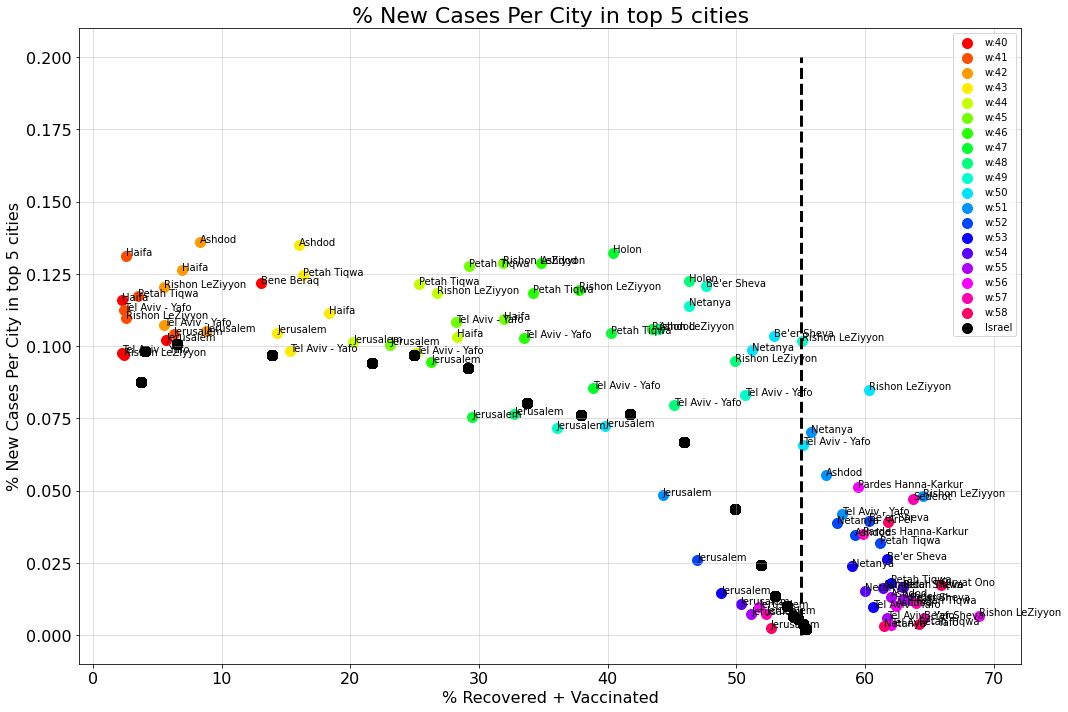

In [25]:
fig, ax = plt.subplots(1, 1)
pearson_coeff = []
spearman_coeff = []
colors = get_cmap(20)
num_cities = 5
for i, (w, df_w) in enumerate(geo_stats_40.groupby('weeks_from')):
    df_w = df_w.sort_values(ascending=False, by='new_cases_on_date')
    df_w = df_w.iloc[:num_cities,:]
    percentage_accumulated_r = df_w['percentage_accumulated_vaccination_second_dose'] + df_w['percentage_accumulated_recoveries']
#     percentage_new_cases = 100 * (df_w['new_cases_on_date'] / df_w['new_cases_on_date_country'])
#     percentage_new_cases =  df_w['percentage_new_cases_on_date'] #- df_w['percentage_new_cases_on_date_country'])
    percentage_new_cases =  df_w['percentage_new_cases_on_date'] 
    df_w['percentage_new_cases'] = percentage_new_cases
    ax.scatter(percentage_accumulated_r, percentage_new_cases, label=f'w:{w}', color=colors[i])
    p_coeff, _ = pearsonr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    s_coeff, _ = spearmanr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    pearson_coeff.append(p_coeff)
    spearman_coeff.append(s_coeff)
    for x, y, c in zip(percentage_accumulated_r, percentage_new_cases, df_w['town_english']):
        plt.text(x, y, c)
ax.scatter(geo_stats_40.percentage_accumulated_immuned_country, geo_stats_40.percentage_new_cases_on_date_country, c='k', label='Israel')
ax.set_xlabel('% Recovered + Vaccinated')
ax.set_title(f'% New Cases Per City in top {num_cities} cities')
ax.set_ylabel(f'% New Cases Per City in top {num_cities} cities')
ax.legend()
ax.grid()
ax.plot([55, 55], [0, 0.2], linestyle='--', linewidth=3, color='k')
ax.plot()

In [26]:
df_w51 = geo_stats[geo_stats.weeks_from == 51]
df_w51 = df_w51.sort_values(ascending=False, by='new_cases_on_date')
df_w51 = df_w51.iloc[:200,:]
percentage_accumulated_r = df_w51['percentage_accumulated_vaccination_second_dose'] + df_w51['percentage_accumulated_recoveries']
percentage_new_cases =  df_w51['percentage_new_cases_on_date'] #- df_w['percentage_new_cases_on_date_country'])
df_w51['percentage_new_cases'] = percentage_new_cases
df_w51s = df_w51.sort_values(by='percentage_new_cases')
young_cities = df_w51s[df_w51s.percentage_new_cases <= 55].city
print(f"young cities:\n{young_cities.values}")
old_cities = df_w51s[df_w51s.percentage_new_cases <= 55].city
print(f"old cities:\n{old_cities.values}")

young cities:
['אום אל-פחם' 'קריית שמונה' 'שוהם' 'רמת השרון' 'טייבה' 'שפרעם' 'טמרה'
 'גבעת שמואל' 'אריאל' 'באר יעקב' "סח'נין" 'תל מונד' 'באקה אל-גרביה'
 'הוד השרון' 'גבעתיים' 'רמת ישי' 'מודיעין-מכבים-רעות*' 'טירת כרמל'
 'כפר כנא' 'טירה' 'הרצלייה' 'מזכרת בתיה' 'חורה' 'עראבה' 'כפר סבא' 'ערערה'
 "ג'דיידה-מכר" 'ירוחם' 'יקנעם עילית' 'כפר קאסם' 'פוריידיס' 'קלנסווה'
 'ביתר עילית' 'מגאר' 'נחף' 'ביר אל-מכסור' 'כפר קרע' 'גדרה' 'רמת גן'
 'דייר אל-אסד' 'כסיפה' 'קריית אונו' 'כרמיאל' 'ערערה-בנגב' 'רעננה'
 'מבשרת ציון' 'גן יבנה' "ג'סר א-זרקא" 'עתלית' 'תל שבע' 'בני ברק'
 'כפר מנדא' 'קריית ים' 'מודיעין עילית' 'כאבול' 'יפיע' 'ריינה' 'נשר'
 'קריית ביאליק' 'דבורייה' 'דייר חנא' 'גני תקווה' 'דאלית אל-כרמל' 'בסמ"ה'
 'אכסאל' 'ירכא' 'אלעד' 'בית שמש' 'חיפה' 'תל אביב -יפו' 'חולון' 'אילת'
 'שעב' 'לקיה' 'חצור הגלילית' 'יבנה' 'כפר יונה' 'פתח תקווה' 'עין מאהל'
 'צור הדסה' "מג'ד אל-כרום" 'בוקעאתא' 'שגב-שלום' 'כוכב יאיר' 'עפולה'
 'קריית מוצקין' 'מעלה עירון' 'נהרייה' 'יהוד' 'זכרון יעקב' 'ראשון לציון'
 'עספיא' 'ירושלים'

Text(0, 0.5, '% New Cases Per City in top 5 cities')

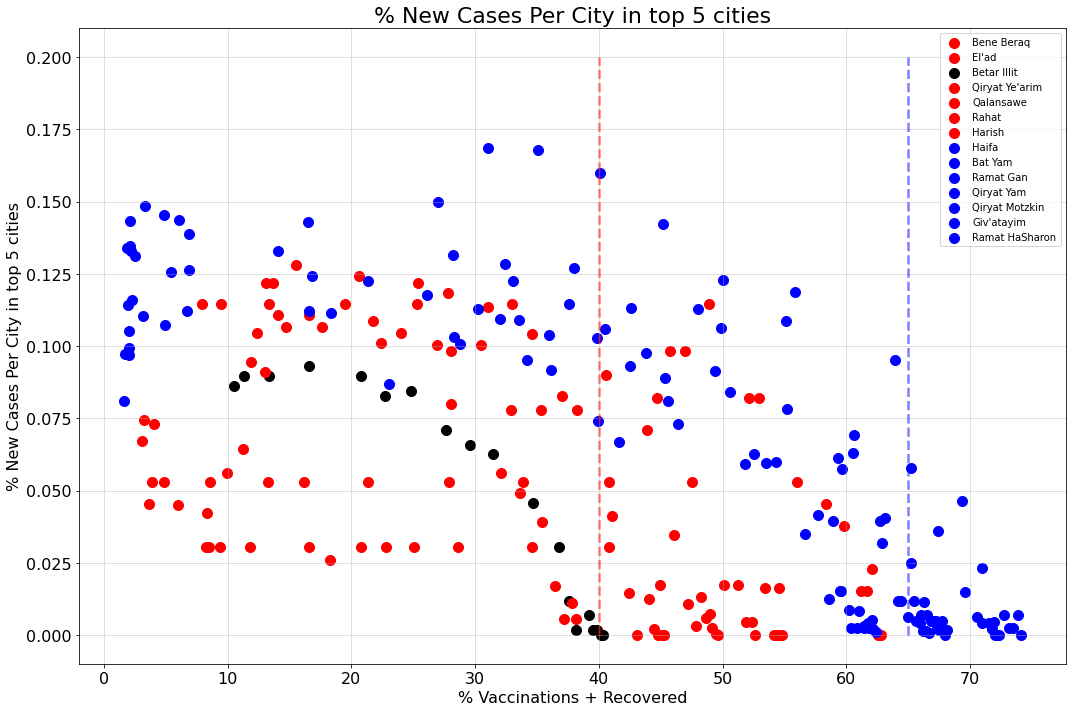

In [27]:
colors_a = get_cmap(20)
old_cities = ['חיפה', 'בת ים', 'רמת גן', 'קריית ים', 'קריית מוצקין', 'גבעתיים','רמת השרון']
young_cities = ['בני ברק', 'אלעד', 'ביתר עילית', 'קריית יערים', 'קלנסווה', 'רהט','חריש']
young_median= [ 'מודיעין עלית',
   'ביתר עילית',
   'אלעד',
#    'חורה',
#    'כסיפה',
   'בית שמש',
#    'רהט',
   'בני ברק',
#    'כפר קאסם',
#    'אום אל-פחם',
#    'כפר כנא',
   'ירושלים',
#    'באקה אל גרבייה',
#    'טייבה',
#    'טמרה',
#    "ג'דיידה-מכר",
   'אופקים',
#    'מגאר',
   'טירה',
#    'נצרת',
   'גן יבנה',
   'מעלה אדומים',
   'באר יעקב',
   'מודיעין-מכבים',
   'גדרה',
   'לוד',
   'גבעת שמואל'
   ]
old_median_y2o = ['אשקלון',
   'מבשרת ציון',
   'מעלות-תרשיחא',
   'טירת כרמל',
   'חדרה',
   'נס ציונה',
   'פתח תקווה',
   'קריית אתא',
   'הוד השרון',
   'תל אביב-יפו',
   'נתניה',
   'יהוד',
   'גבעתיים',
   'ראשון לציון',
   'חולון',
   'רמת גן',
   'כרמיאל',
   'נשר',
   'כפר סבא',
   'נהרייה',
   'רעננה',
   'חיפה',
   'הרצלייה',
   'נצרת עלית',
   'בת ים']

old_median = [old_median_y2o[len(old_median_y2o) - i - 1] for i in range(len(old_median_y2o))]
young_c = 'r'
old_c = 'b'
# for i, c in enumerate(young_cities + old_cities ):
#     city_data = geo_stats_40[geo_stats_40['town'] == c]
#     percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
#     percentage_new_cases_ashdod =  city_data['percentage_new_cases_on_date'] 
#     plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c, color=colors_a[i])
for c in young_cities:
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
    percentage_new_cases_ashdod =  city_data['percentage_new_cases_on_date'] 
#     plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c, color=young_c)
    if c == 'ביתר עילית':
        plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english, color='k')
    else:
        plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english, color=young_c)
for c in old_cities:
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
    percentage_new_cases_ashdod =  city_data['percentage_new_cases_on_date'] 
    plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english, color=old_c)
# city_data = geo_stats_40[geo_stats_40['town'] == 'חולון']
# percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
# percentage_new_cases_ashdod =  city_data['percentage_new_cases_on_date'] 
# plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c, color='g')
plt.plot([40, 40], [0, 0.2], color='r', linestyle='--', alpha=0.5)
plt.plot([65, 65], [0, 0.2], color='b', linestyle='--', alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('% Vaccinations + Recovered')
plt.title(f'% New Cases Per City in top {num_cities} cities')
plt.ylabel(f'% New Cases Per City in top {num_cities} cities')

In [28]:
# geo_sorted = geo_stats[geo_stats.weeks_from == 52].sort_values(ascending=False, by='new_cases_on_date')
# geo_sorted = geo_sorted[geo_sorted.num_population > 500]
# towns_by_vacc = geo_sorted.sort_values(by='percentage_accumulated_vaccination_second_dose')[['town']]
# lowest_vacc = towns_by_vacc.iloc[:5].values
# highest_vacc = towns_by_vacc.iloc[-10:].values
# high_c = get_cmap(20, 'winter')
# low_c = get_cmap(20, 'hot')
# for c in range(lowest_vacc.size):
#     city_data = geo_stats_40[geo_stats_40['town'] == lowest_vacc[c][0]]
#     c_english = city_data.town_english.iloc[0]
#     n_pop = city_data.num_population.iloc[0]
#     percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
#     percentage_new_cases_ashdod =  100* (city_data['new_cases_on_date'] / city_data['new_cases_on_date_country'])
# #     plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english,  c=city_data.weeks_from, cmap='Greens')
#     plt.plot(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=f"{c_english}:{n_pop}", color=low_c[c], marker='*')

# for c in range(highest_vacc.size):
#     city_data = geo_stats_40[geo_stats_40['town'] == highest_vacc[c][0]]
#     c_english = city_data.town_english.iloc[0]
#     n_pop = city_data.num_population.iloc[0]
#     percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
#     percentage_new_cases_ashdod =  100* (city_data['new_cases_on_date'] / city_data['new_cases_on_date_country'])
# #     plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english, c=city_data.weeks_from, cmap='Reds')
#     plt.plot(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=f"{c_english}:{n_pop}", color=high_c[c], marker='*')

# # city_data = geo_stats_40[geo_stats_40['town'] == 'ירושלים']
# # percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
# # percentage_new_cases_ashdod =  100 * (city_data['new_cases_on_date'] / city_data['new_cases_on_date_country'])
# # plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c, color='g')
# # plt.plot([40, 40], [0, 0.2], c='r', linestyle='--', alpha=0.5)
# # plt.plot([70, 70], [0, 0.2], color='b', linestyle='--', alpha=0.5)
# plt.grid()
# plt.legend()
# plt.xlabel('% Vaccinations + Recovered')
# plt.title(f'% New Cases Per City in top {num_cities} cities')
# plt.ylabel(f'% New Cases Per City in top {num_cities} cities')

In [29]:
geo_stats.sort_values(ascending=True, by=['weeks_from','percentage_accumulated_immuned'])[geo_stats.weeks_from == 46][['town', 'num_population', 'new_cases_on_date', 'percentage_new_cases_on_date', 'percentage_accumulated_immuned']]

<ipython-input-29-a6bbc31497f7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  geo_stats.sort_values(ascending=True, by=['weeks_from','percentage_accumulated_immuned'])[geo_stats.weeks_from == 46][['town', 'num_population', 'new_cases_on_date', 'percentage_new_cases_on_date', 'percentage_accumulated_immuned']]


town  num_population  new_cases_on_date  \
12200    קצר א-סר         2455.23                0.0   
12201   ביר הדאג'         5859.62                0.0   
12202    אום בטין         4267.03                0.0   
12203     אל סייד         5862.58                0.0   
12183    שגב-שלום        10906.04                5.0   
...           ...             ...                ...   
12197  נוף איילון         2120.12                4.0   
12257    חשמונאים         2767.93                6.0   
12127       סביון         4053.69                2.0   
12180       להבים         6412.31                4.0   
12138        עומר         7523.55                4.0   

       percentage_new_cases_on_date  percentage_accumulated_immuned  
12200                      0.000000                        0.325835  
12201                      0.000000                        0.477847  
12202                      0.000000                        0.726501  
12203                      0.000000                        0.750523  
12183                      0.045846                        4.309539  
...                             ...                             ...  
12197                      0.188669                       51.553686  
12257                      0.216768                       56.937856  
12127                      0.049338                       57.823859  
12180                      0.062380                       59.027090  
12138                      0.053166                       60.503353  

[262 rows x 5 columns]

In [30]:
# geo_sorted = geo_stats.sort_values(ascending=True, by=['weeks_from','percentage_accumulated_immuned'])
# # geo_sorted = geo_sorted[geo_sorted.percentage_accumulated_immuned<=50]
# # towns_by_vacc = geo_sorted.sort_values(by='new_cases_on_date')[['town']]
# lowest_vacc = geo_sorted[['town']].iloc[:10].values
# highest_vacc = geo_sorted[['town']].iloc[-10:].values

# high_c = get_cmap(20, 'winter')
# low_c = get_cmap(20, 'hsv')
# for c in range(lowest_vacc.size):
#     city_data = geo_stats_40[geo_stats_40['town'] == lowest_vacc[c][0]]
#     c_english = city_data.town_english.iloc[0]
#     percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
#     percentage_new_cases_ashdod =  city_data['new_cases_on_date']
# #     plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english,  c=city_data.weeks_from, cmap='Greens')
#     plt.plot(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english, color=low_c[c], marker='*')
# # for c in range(highest_vacc.size):
# #     city_data = geo_stats_40[geo_stats_40['town'] == highest_vacc[c][0]]
# #     c_english = city_data.town_english.iloc[0]
# #     percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
# #     percentage_new_cases_ashdod =  city_data['percentage_new_cases_on_date']
# # #     plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english,  c=city_data.weeks_from, cmap='Greens')
# #     plt.plot(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english, color=high_c[c], marker='*')

# plt.grid()
# plt.legend()
# plt.xlabel('% Vaccinations + Recovered')
# plt.title(f'% New Cases Per City in top {num_cities} cities')
# plt.ylabel(f'% New Cases Per City in top {num_cities} cities')

In [31]:
# percentage_accumulated_tot_r = geo_stats_40.percentage_accumulated_vaccination_second_dose + geo_stats_40.percentage_accumulated_recoveries
# p_coeff, _ = pearsonr(percentage_accumulated_tot_r, geo_stats_40.percentage_new_cases_on_date)
# s_coeff, _ = spearmanr(percentage_accumulated_tot_r, geo_stats_40.percentage_new_cases_on_date)
# # Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
# print("------- percentage new cases -----------")
# print(f"from week 40, pearson coeff:{p_coeff}")
# print(f"from week 40, spearman coeff:{s_coeff}")

# print("------- new cases -----------")
# accumulated_tot_r = geo_stats_40.accumulated_vaccination_second_dose + geo_stats_40.accumulated_recoveries
# p_coeff, _ = pearsonr(accumulated_tot_r, geo_stats_40.new_cases_on_date)
# s_coeff, _ = spearmanr(accumulated_tot_r, geo_stats_40.new_cases_on_date)
# # Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
# print(f"from week 40, pearson coeff:{p_coeff}")
# print(f"from week 40, spearman coeff:{s_coeff}")


# print("------- percentage cases per week -----------")
# a=[print(f"w:{w}, pearon:{p}, spearman:{s}") for (w, p, s) in zip(geo_stats_40.weeks_from.unique(), pearson_coeff, spearman_coeff) ]
# plt.scatter(range(len(pearson_coeff)), pearson_coeff, label='pearson')
# plt.scatter(range(len(spearman_coeff)), spearman_coeff, label='spearman')
# plt.grid()

## organize vaccinations per age

In [32]:
geo_vacc_per_age = geo_vacc_per_age.replace(to_replace={'<15': 4})

In [33]:
geo_vacc_per_age['Date'] = pd.to_datetime(geo_vacc_per_age['Date'],format='%Y-%m-%d')
geo_vacc_per_age = geo_vacc_per_age.rename(columns={'Date':'date'})

In [34]:
geo_vacc_per_age.columns

Index(['CityName', 'CityCode', 'date', 'first_dose_0-19', 'first_dose_20-29',
       'first_dose_30-39', 'first_dose_40-49', 'first_dose_50-59',
       'first_dose_60-69', 'first_dose_70-79', 'first_dose_80-89',
       'first_dose_90+', 'second_dose_0-19', 'second_dose_20-29',
       'second_dose_30-39', 'second_dose_40-49', 'second_dose_50-59',
       'second_dose_60-69', 'second_dose_70-79', 'second_dose_80-89',
       'second_dose_90+'],
      dtype='object')

In [35]:
float_columns = ['first_dose_0-19', 'first_dose_20-29', 'first_dose_30-39', 'first_dose_40-49', 
                 'first_dose_50-59', 'first_dose_60-69', 'first_dose_70-79', 'first_dose_80-89', 'first_dose_90+', 
                 'second_dose_0-19', 'second_dose_20-29', 'second_dose_30-39', 'second_dose_40-49', 'second_dose_50-59',
                 'second_dose_60-69', 'second_dose_70-79', 'second_dose_80-89', 'second_dose_90+']
geo_vacc_per_age[float_columns] = geo_vacc_per_age[float_columns].astype(float)

In [36]:
agg_dict = {k:'sum' for k in float_columns}
geo_vacc_per_age = geo_vacc_per_age.groupby('date', as_index=False).agg(agg_dict)

In [37]:
agg_dict_weeks = {k:'last' for k in float_columns}
agg_dict_weeks['date'] = 'last'
geo_vacc_per_age['weeks_from'] = np.round((geo_vacc_per_age['date'] - pd.to_datetime('2020-03-21',format='%Y-%m-%d')).dt.days / 7, 1).astype(int)
geo_vacc_per_age = geo_vacc_per_age.groupby('weeks_from', as_index=False).agg(agg_dict_weeks)

In [38]:
geo_vacc_per_age[['weeks_from','date']][geo_vacc_per_age['date']>=pd.to_datetime('2020-07-01',format='%Y-%m-%d')]

weeks_from       date
0           39 2020-12-25
1           40 2021-01-01
2           41 2021-01-08
3           42 2021-01-15
4           43 2021-01-22
5           44 2021-01-29
6           45 2021-02-05
7           46 2021-02-12
8           47 2021-02-19
9           48 2021-02-26
10          49 2021-03-05
11          50 2021-03-12
12          51 2021-03-19
13          52 2021-03-26
14          53 2021-04-02
15          54 2021-04-09
16          55 2021-04-16
17          56 2021-04-23
18          57 2021-04-30
19          58 2021-05-07
20          59 2021-05-08

## edit vaccinations data

In [39]:
geo_for_vacc = geo_stats[['date','accumulated_cases', 'accumulated_recoveries','accumulated_hospitalized',
                              'accumulated_deaths', 'accumulated_diagnostic_tests', 
                               'accumulated_vaccination_first_dose', 'accumulated_vaccination_second_dose']]

In [40]:
geo_for_vacc = geo_for_vacc.replace(to_replace={'<15': 4})

In [41]:
geo_for_vacc['date'] = pd.to_datetime(geo_for_vacc['date'],format='%Y-%m-%d')
geo_for_vacc = geo_for_vacc[geo_for_vacc['date'] >= pd.to_datetime('2020-03-21',format='%Y-%m-%d')]

In [42]:
geo_for_vacc[['accumulated_cases', 'accumulated_recoveries', 'accumulated_hospitalized',
              'accumulated_deaths', 'accumulated_diagnostic_tests', 
              'accumulated_vaccination_first_dose', 'accumulated_vaccination_second_dose']] = geo_for_vacc[['accumulated_cases', 'accumulated_recoveries', 'accumulated_hospitalized',
              'accumulated_deaths', 'accumulated_diagnostic_tests', 
              'accumulated_vaccination_first_dose', 'accumulated_vaccination_second_dose']].astype(float)

In [43]:
vaccinations_data = geo_for_vacc.groupby('date', as_index=False).agg(
    {'accumulated_cases':'sum',
     'accumulated_recoveries':'sum',
     'accumulated_hospitalized':'sum',
     'accumulated_diagnostic_tests':'sum',
    'accumulated_deaths':'sum',
     'accumulated_vaccination_first_dose':'sum',
     'accumulated_vaccination_second_dose':'sum'
    })

In [44]:
vaccinations_data['weeks_from'] = np.round((vaccinations_data['date'] - vaccinations_data['date'][0]).dt.days / 7, 1).astype(int)

In [45]:
# vaccinations_data[vaccinations_data['date'] == '2021-02-18']
# closed_schools = [(0, 6), (14, 23), (25, 31), (41, 45)]
# schools_opened = [()]

In [46]:
vaccinations_data = vaccinations_data.groupby('weeks_from', as_index=False).agg(
    {'accumulated_cases':'last',
     'accumulated_recoveries':'last',
     'accumulated_hospitalized':'last',
     'accumulated_diagnostic_tests':'last',
    'accumulated_deaths':'last',
     'accumulated_vaccination_first_dose':'last',
     'accumulated_vaccination_second_dose':'last',
     'date':'last'
    })

In [47]:
# change names in data from hebrew to english:
hospital_data_columns_english = ['date', 'num_hospitalizations', 'percentage_women_hospilizations', 'mean_age_hospilizations', 'variance_age_hospilizations', 
                                'num_ventilizations', 'percentage_women_ventilizations','mean_age_ventilizations', 'variance_age_ventilizations',
                                'easy_cases', 'percentage_women_easy_cases', 'mean_age_easy_cases', 'variance_age_easy_cases',
                                'medium_severity', 'percentage_women_medium_severity', 'mean_age_medium_severity', 'variance_age_medium_severity',
                                'severe_cases', 'percentage_women_severe_cases', 'mean_age_severe_cases', 'variance_age_severe_cases', 'cumulative_severe_cases']
column_names_to_english = {k:v for k,v in zip(hospital_data.columns, hospital_data_columns_english)}
hospital_data = hospital_data.rename(columns = column_names_to_english)

In [48]:
hospital_data['date'] = pd.to_datetime(hospital_data['date'],format='%Y-%m-%d')

In [49]:
# mean_age = hospital_data['mean_age_severe_cases']
# plt.plot(hospital_data['date'], mean_age, marker='*')
# plt.grid()

## organize age and gender data

In [50]:
# change names of male, female and unknown to numbers
gender_name_replace = {'זכר' : 0, 
                       'נקבה': 1,
                       'לא ידוע' : -1}
age_gender_test_data['gender'] = age_gender_test_data['gender'].replace(to_replace = gender_name_replace)

In [51]:
# changing all values that say <15 to 7 which is the mean value
age_gender_test_data = age_gender_test_data.replace(to_replace={'<15': 1,
                                                               '80+': '80-100'})
young_test_data = young_test_data.replace(to_replace={'<15': 1})
age_gender_test_data = age_gender_test_data.dropna()

In [52]:
# split ages with - and make two columns
age_gender_test_data[['min_age', 'max_age']] =age_gender_test_data['age_group'].str.split('-',expand=True)
young_test_data[['min_age', 'max_age']] =young_test_data['age_group'].str.split('-',expand=True)

In [53]:
# change date format to datetime and add column of weeks from
age_gender_test_data['first_week_day'] = pd.to_datetime(age_gender_test_data['first_week_day'],format='%Y-%m-%d')
age_gender_test_data['last_week_day'] = pd.to_datetime(age_gender_test_data['last_week_day'],format='%Y-%m-%d')
young_test_data['first_week_day'] = pd.to_datetime(young_test_data['first_week_day'],format='%Y-%m-%d')
young_test_data['last_week_day'] = pd.to_datetime(young_test_data['last_week_day'],format='%Y-%m-%d')

In [54]:
# change dtype of float columns from object to float
age_gender_test_data[['min_age', 'max_age', 'weekly_tests_num', 'weekly_cases', 'weekly_deceased']] = age_gender_test_data[['min_age', 'max_age', 'weekly_tests_num', 'weekly_cases', 'weekly_deceased']].astype(float)
young_test_data[['min_age', 'max_age', 'weekly_tests_num', 'weekly_cases', 'weekly_newly_tested']] = young_test_data[['min_age', 'max_age', 'weekly_tests_num', 'weekly_cases', 'weekly_newly_tested']].astype(float)

In [55]:
# make a column which is the weeks from the beginning of the pandemic
age_gender_test_data['weeks_from'] = np.round((age_gender_test_data['last_week_day'] - age_gender_test_data['last_week_day'][0]).dt.days / 7, 1).astype(int)
young_test_data['weeks_from'] = np.round((young_test_data['last_week_day'] - young_test_data['last_week_day'][0]).dt.days / 7, 1).astype(int)

In [56]:
# keep only relevant columns
columns_age_gender = ['weeks_from', 'min_age', 'max_age', 'gender', 'weekly_tests_num', 'weekly_cases', 'weekly_deceased']
age_gender_test_data = age_gender_test_data[columns_age_gender]

In [57]:
# remove gender information
age_gender_test_data = age_gender_test_data.groupby(['weeks_from', 'min_age'], as_index=False).agg({'weeks_from': 'first',
                                                            'min_age': 'first', 
                                                            'max_age': 'first',
                                                           'gender':'sum',
                                                           'weekly_tests_num': 'sum',
                                                           'weekly_cases':'sum',
                                                           'weekly_deceased':'sum'})
young_test_data = young_test_data.groupby(['weeks_from', 'min_age'], as_index=False).agg({'weeks_from': 'first',
                                                            'min_age': 'first', 
                                                            'max_age': 'first',
                                                           'region':'sum',
                                                           'weekly_tests_num': 'sum',
                                                           'weekly_cases':'sum',
                                                           'weekly_newly_tested': 'sum'})
young_test_data = young_test_data.drop(columns='region')

## get percentages of each age group

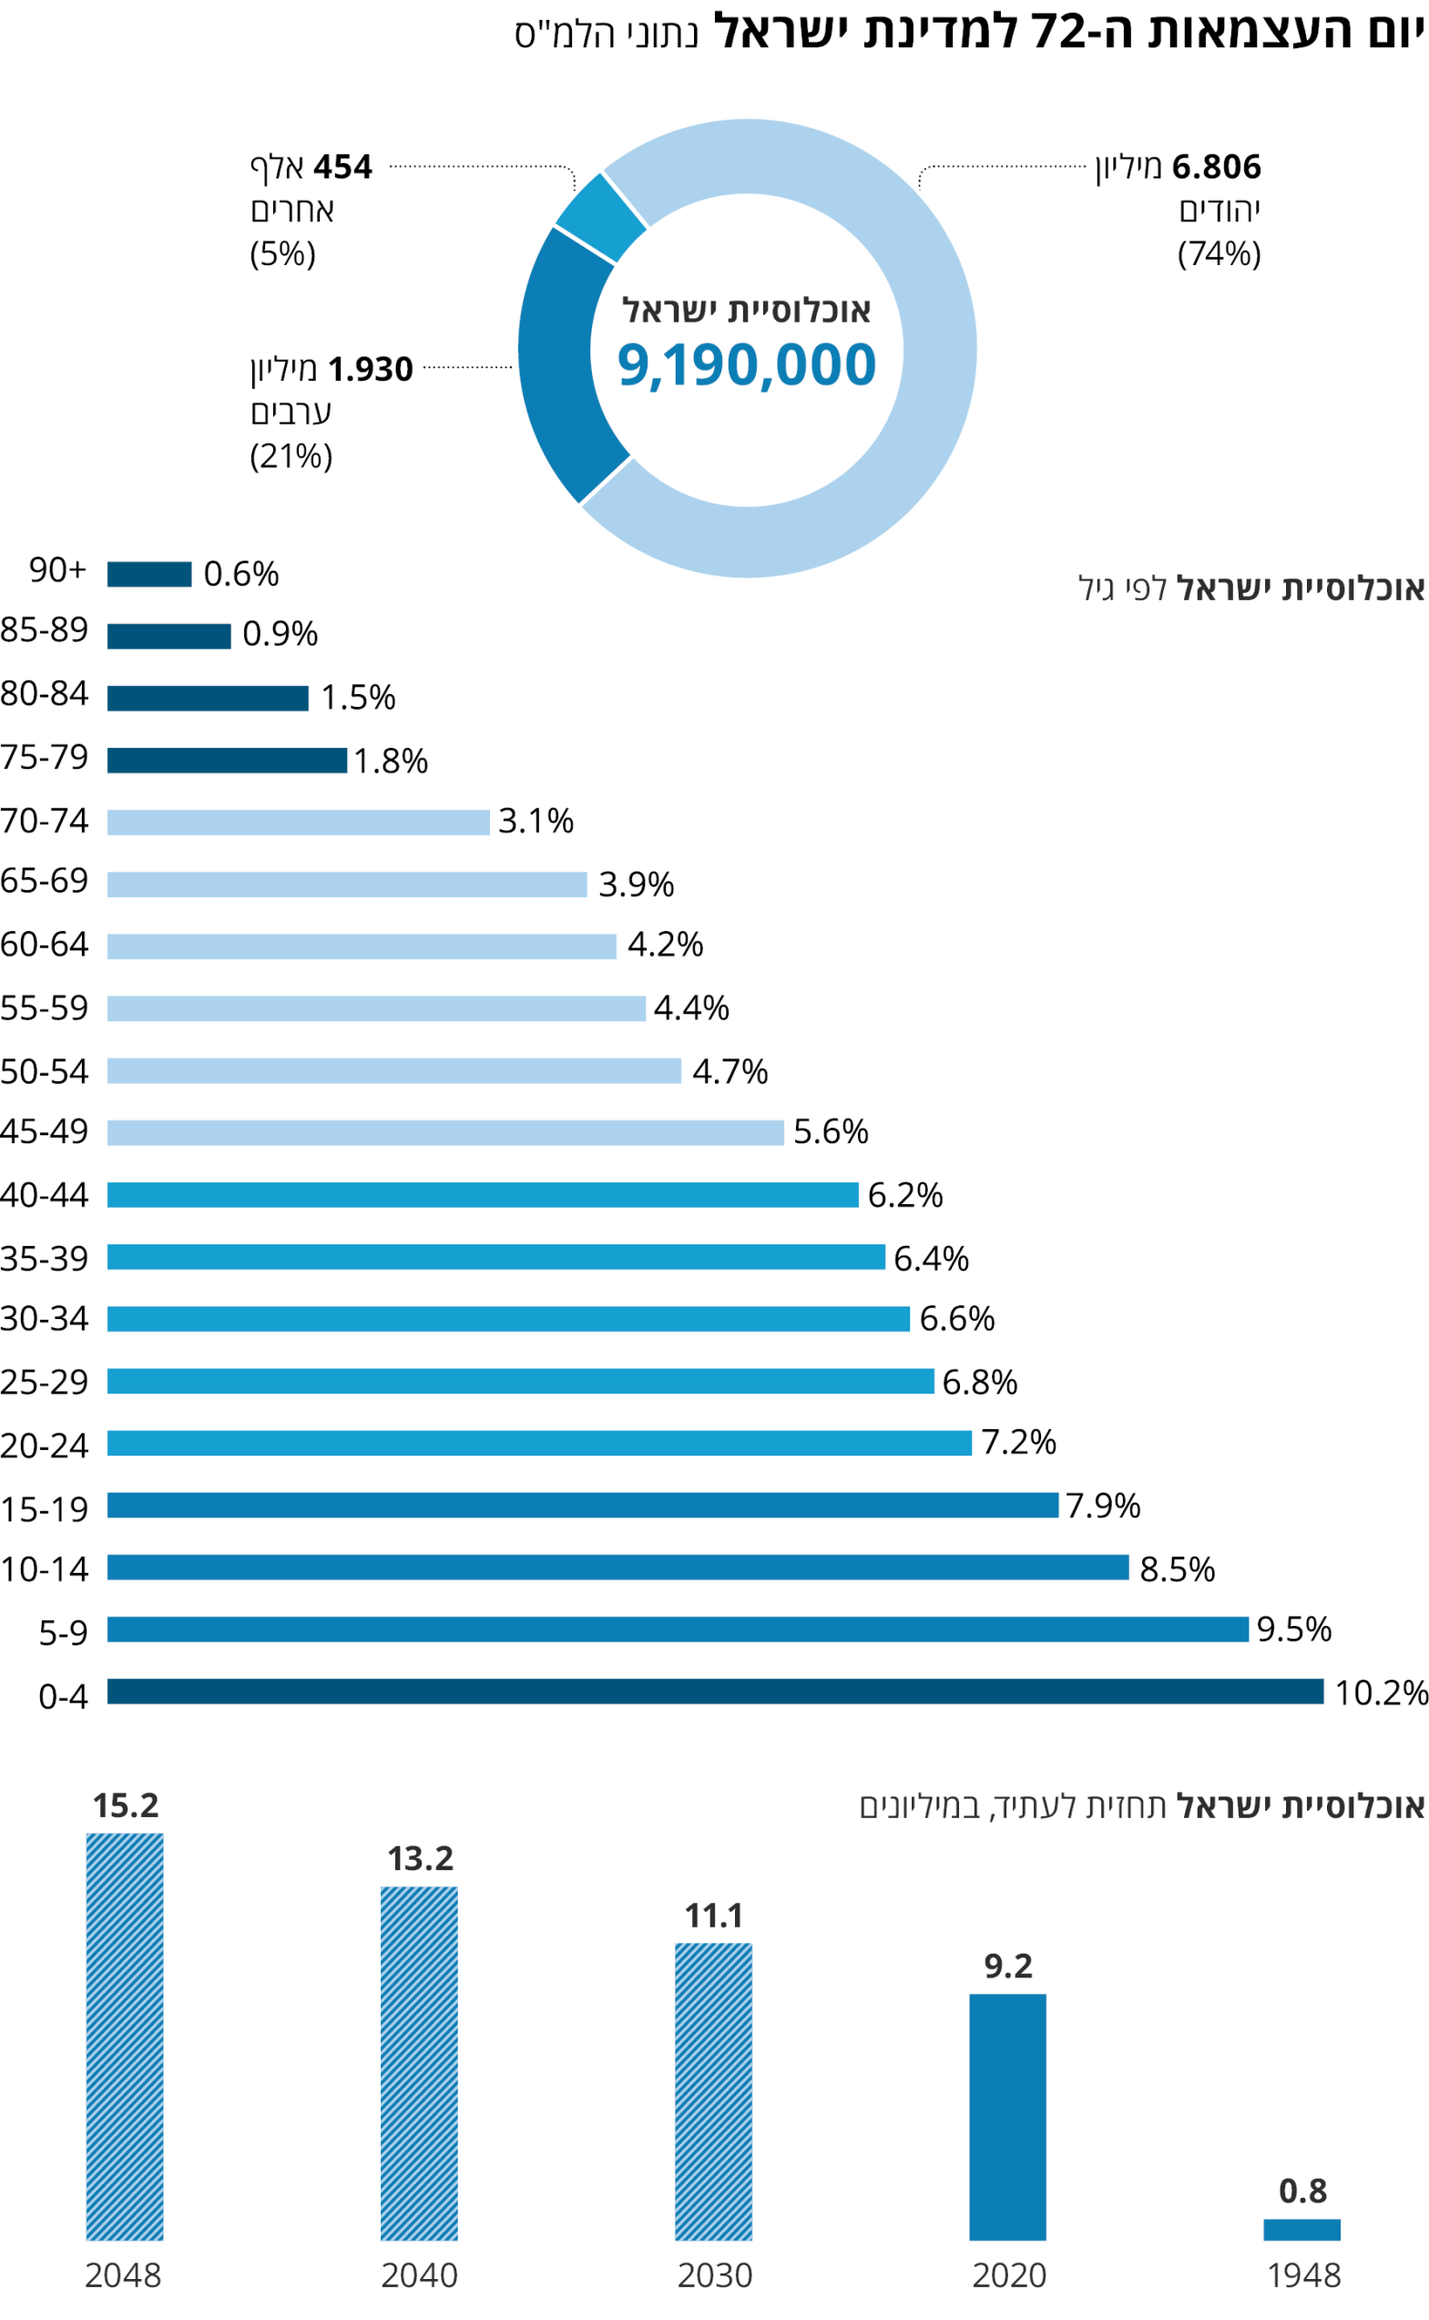

In [58]:
total_population = people_per_age["num_people"].sum()

In [59]:
ages_young = [(a0, a1) for (a0, a1) in zip(young_test_data.min_age.unique(), young_test_data.max_age.unique())]
ages_all = [(a0, a1) for (a0, a1) in zip(age_gender_test_data.min_age.unique(), age_gender_test_data.max_age.unique())]

In [60]:
percentage_in_population_young = get_percentage_people_per_age_group(people_per_age, ages_young)
num_in_population_young = {k: v * total_population / 100 for (k, v) in percentage_in_population_young.items()}
age_info_in_population_young = {'max_age': list(young_test_data.max_age.unique()),
                         'percentage_age': list(percentage_in_population_young.values()),
                         'total_age_in_population': list(num_in_population_young.values())}
age_info_in_population_young_df = pd.DataFrame.from_dict(age_info_in_population_young)

In [61]:
percentage_in_population_all = get_percentage_people_per_age_group(people_per_age, ages_all)
num_in_population_all = {k: v * total_population / 100 for (k, v) in percentage_in_population_all.items()}
age_info_in_population_all = {'max_age': list(age_gender_test_data.max_age.unique()),
                         'percentage_age': list(percentage_in_population_all.values()),
                         'total_age_in_population': list(num_in_population_all.values())}
age_info_in_population_df = pd.DataFrame.from_dict(age_info_in_population_all)

In [62]:
# merge population data with covid data for both tables
age_gender_test_data = pd.merge(age_info_in_population_df, age_gender_test_data, how='right', on='max_age')
young_test_data = pd.merge(age_info_in_population_young_df, young_test_data, how='right', on='max_age')

In [63]:
# create aggregated table of total number of cases for each week
test_data_agg_weeks = age_gender_test_data.groupby('weeks_from', as_index=False).agg({'weekly_tests_num':'sum',
                                                                                      'weekly_deceased':'sum',
                                                                                      'weekly_cases':'sum'})
test_data_young_agg_weeks = young_test_data.groupby('weeks_from', as_index=False).agg({'weekly_tests_num':'sum',
                                                                                      'weekly_newly_tested':'sum',
                                                                                       'weekly_cases':'sum'})

## draw results for older data 

In [64]:
def draw_per_total(table_per_age, total_table, with_dead = True, with_new = False, seperate_tables = False):
    colors = get_cmap(n=20)
    if not seperate_tables:
        if with_dead or with_new:
            fig, ax = plt.subplots(3, 1)
        else:
            fig, ax = plt.subplots(2, 1)
    for i, (a, df_a) in enumerate(table_per_age.groupby(['min_age', 'max_age'])):
        n_tests = np.array(df_a['weekly_tests_num'])
        n_pos = np.array(df_a['weekly_cases'])
        n_weeks = np.array(df_a['weeks_from'])
        n_total_pos = np.array(total_table['weekly_cases'])
        n_total_tests = np.array(total_table['weekly_tests_num'])
        if seperate_tables:
            if (with_dead or with_new):
                fig, ax = plt.subplots(3, 1)
            else:
                fig, ax = plt.subplots(2, 1)
        if with_dead:
            n_total_dec = np.array(total_table['weekly_deceased'])
            n_dec = np.array(df_a['weekly_deceased'])
            ax[2].plot(n_weeks, 100 * n_dec / n_total_dec, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
            ax[2].set_title('% of dead per age')
            ax[2].set_xlabel('Weeks from start of Covid')
        if with_new:
            n_new = np.array(df_a['weekly_newly_tested'])
            n_total_new = np.array(test_data_young_agg_weeks['weekly_newly_tested'])
            ax[2].plot(n_weeks, 100 * n_new / n_total_new, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
            ax[2].set_title('% of new tests per age')
            ax[2].set_xlabel('Weeks from start of Covid')
        percentage_in_population = df_a.percentage_age.unique().item()
        ax[0].plot(n_weeks, 100 * n_pos / n_total_pos, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
#         ax[0].plot(n_weeks, np.ones(shape=n_weeks.size) + percentage_in_population, color=colors[i])
        ax[1].plot(n_weeks, 100 * n_tests / n_total_tests, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
#         ax[1].plot(n_weeks, np.ones(shape=n_weeks.size) + percentage_in_population, color=colors[i])
        if seperate_tables:
            ax[0].legend()
            ax[1].legend()
            ax[0].grid()
            ax[1].grid()
            ax[0].set_title('% of positive cases per age')
            ax[1].set_title('% of tests per age')
            ax[0].set_ylabel('% of positive cases from total cases')
            if with_dead or with_new:
                ax[2].legend()
                ax[2].grid()
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    ax[0].set_title('% of positive cases per age')
    ax[1].set_title('% of tests per age')
    ax[0].set_ylabel('% of positive cases from total cases')
    if with_dead or with_new:
        ax[2].legend()
        ax[2].grid()
    return fig, ax

In [65]:
def draw_per_population(data_per_age, with_dead=True, with_new=False):
    colors = get_cmap(n=20)
    if with_dead or with_new:
        fig, ax = plt.subplots(3, 1)
    else:
        fig, ax = plt.subplots(2, 1)
    for i, (a, df_a) in enumerate(data_per_age.groupby(['min_age', 'max_age'])):
        n_tests = np.array(df_a['weekly_tests_num'])
        n_pos = np.array(df_a['weekly_cases'])
        n_weeks = np.array(df_a['weeks_from'])
        n_population = df_a['total_age_in_population'].mean()
        ax[0].plot(n_weeks, 100 * n_pos / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        ax[1].plot(n_weeks, 100 * n_tests / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_dead:
            n_dec = np.array(df_a['weekly_deceased'])
            ax[2].plot(n_weeks, 100 * n_dec / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_new:
            n_new = np.array(df_a['weekly_newly_tested'])
            ax[2].plot(n_weeks, 100 * n_new / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
            ax[2].set_title('number dead/population per age')
    
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    ax[0].set_title('Positive cases/population per age ')
    ax[1].set_title('number of tests/population per age')
    ax[0].set_ylabel('% of positive cases from total cases')
    if with_dead or with_new:
        ax[2].legend()
        ax[2].grid()
        ax[2].set_xlabel('Weeks from start of Covid')
    return fig, ax

In [76]:
57-38

19

In [77]:
infect_dec=np.zeros((19))
vacc_start_week = 0
infect_dec[:2 + vacc_start_week]=1-1
infect_dec[2+vacc_start_week:3+vacc_start_week]=1-0.43
infect_dec[3+vacc_start_week:4+vacc_start_week]=1-0.34
infect_dec[4+vacc_start_week:]=1-0.06
vaccinations_data_out= []
vacc_per_day = np.diff(vaccinations_data.iloc()[:,6])
for i in range(19):
    vaccinations_data_out.append(np.dot(np.expand_dims(infect_dec[:i+1][::-1],axis=0),vacc_per_day[38:38+i+1]))
vaccinations_data_out = np.array([0]*39 + list(vaccinations_data_out), dtype=object).astype(int).reshape(-1)    
total_immuned = vaccinations_data_out + vaccinations_data['accumulated_recoveries']
percentage_immuned = 100 * (total_immuned / total_population)

In [79]:
def draw_vaccinations_percentage(vacc_data, fig, ax, draw_total=False):
    if draw_total:
        infect_dec=np.zeros((19))
        vacc_start_week = 0
        infect_dec[:2 + vacc_start_week]=1-1
        infect_dec[2+vacc_start_week:3+vacc_start_week]=1-0.43
        infect_dec[3+vacc_start_week:4+vacc_start_week]=1-0.34
        infect_dec[4+vacc_start_week:]=1-0.06
        vaccinations_data_out= []
        vacc_per_day = np.diff(vacc_data.iloc()[:,6])
        for i in range(19):
            vaccinations_data_out.append(np.dot(np.expand_dims(infect_dec[:i+1][::-1],axis=0),vacc_per_day[38:38+i+1]))
        vaccinations_data_out = np.array([0]*39 + list(vaccinations_data_out), dtype=object).astype(int).reshape(-1)    
        total_immuned = vaccinations_data_out + vacc_data['accumulated_recoveries']
        percentage_immuned = 100 * (total_immuned / total_population)
        ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('% of population immuned', color=color)  # we already handled the x-label with ax1
        ax2.plot(vacc_data['weeks_from'] , percentage_immuned, marker='.', color=color, linestyle='--',  alpha=0.5)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped

        ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('% of population immuned', color=color)  # we already handled the x-label with ax1
        ax2.plot(vacc_data['weeks_from'] , percentage_immuned, marker='.', color=color, linestyle='--', alpha=0.5)
        ax2.tick_params(axis='y', labelcolor=color)
    else:
        percentage_first = (vacc_data['accumulated_recoveries'] + vacc_data['accumulated_vaccination_first_dose']) * 100 / total_population
        percentage_second =(vacc_data['accumulated_recoveries'] + vacc_data['accumulated_vaccination_second_dose']) * 100 / total_population

        ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('% of population immuned', color=color)  # we already handled the x-label with ax1
        ax2.plot(vacc_data['weeks_from'] , percentage_second, marker='.', color=color,  alpha=0.5)
        ax2.plot(vacc_data['weeks_from'] , percentage_first, marker='*', color=color, linestyle='--',  alpha=0.5)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped

        ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('% of population immuned', color=color)  # we already handled the x-label with ax1
        ax2.plot(vacc_data['weeks_from'] , percentage_second, marker='.', color=color,  alpha=0.5)
        ax2.plot(vacc_data['weeks_from'] , percentage_first, marker='*', color=color, linestyle='--', alpha=0.5)
        ax2.tick_params(axis='y', labelcolor=color)

In [80]:
def draw_per_max(data_per_age, with_dead=True, with_new=False):
    colors = get_cmap(n=20)
    if with_dead or with_new:
        fig, ax = plt.subplots(3, 1)
    else:
        fig, ax = plt.subplots(2, 1)
    for i, (a, df_a) in enumerate(data_per_age.groupby(['min_age', 'max_age'])):
        n_tests = np.array(df_a['weekly_tests_num'])
        n_pos = np.array(df_a['weekly_cases'])
        n_weeks = np.array(df_a['weeks_from'])
        max_pos = np.max(n_pos)
        max_tests = np.max(n_tests)
        ax[0].plot(n_weeks, n_pos / max_pos, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        ax[1].plot(n_weeks, n_tests / max_tests, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_dead:
            n_dec = np.array(df_a['weekly_deceased'])
            max_dec = np.max(n_dec)
            ax[2].plot(n_weeks, n_dec / max_dec, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_new:
            n_new = np.array(df_a['weekly_newly_tested'])
            max_new = np.max(n_new)
            ax[2].plot(n_weeks, n_new / max_new, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
            ax[2].set_title('number dead/max new per age')
    
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
#     ax[0].set_title('# P / max(# P) per age')
#     ax[1].set_title('# P / max(# P)')
    ax[0].set_ylabel('P / max(P) per age')
    if with_dead or with_new:
        ax[2].legend()
        ax[2].grid()
        ax[2].set_xlabel('Weeks from start of Covid')
    return fig, ax

In [81]:
def draw_absolute_numbers(data_per_age, with_dead=True, with_new=False):
    colors = get_cmap(n=20)
    if with_dead or with_new:
        fig, ax = plt.subplots(3, 1)
    else:
        fig, ax = plt.subplots(2, 1)
    for i, (a, df_a) in enumerate(data_per_age.groupby(['min_age', 'max_age'])):
        n_tests = np.array(df_a['weekly_tests_num'])
        n_pos = np.array(df_a['weekly_cases'])
        n_weeks = np.array(df_a['weeks_from'])
        n_population = df_a['total_age_in_population'].mean()
        ax[0].plot(n_weeks, 100 * n_pos, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        ax[1].plot(n_weeks, 100 * n_tests, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_dead:
            n_dec = np.array(df_a['weekly_deceased'])
            ax[2].plot(n_weeks, 100 * n_dec, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_new:
            n_new = np.array(df_a['weekly_newly_tested'])
            ax[2].plot(n_weeks, 100 * n_new , color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
            ax[2].set_title('number dead per age')
    
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    ax[0].set_title('Positive cases per age ')
    ax[1].set_title('number of tests per age')
    ax[0].set_ylabel('Positive cases per age ')
    if with_dead or with_new:
        ax[2].legend()
        ax[2].grid()
        ax[2].set_xlabel('Weeks from start of Covid')
    return fig, ax

In [82]:
def draw_lockdowns(fig, ax, max_y0, max_y1):
    lockdown_times = [(25, 30),
                     (41,47)]
    colors = ['k', 'k']
    for i, l in enumerate(lockdown_times):
        rec = patches.Rectangle([l[0], 0], l[1]-l[0], max_y0, alpha=0.1, color=colors[i])
        ax[0].add_patch(rec)
        rec = patches.Rectangle([l[0], 0], l[1]-l[0], max_y1, alpha=0.1, color=colors[i])
        ax[1].add_patch(rec)

In [83]:
def add_important_information(fig, ax, max_y0, max_y1):
    # herd immunity israel: week 50
    # vacc week per age: 
    # 60+ : 20.12.20, week 38
    # 50+ : 12.1.21, week 41
    # 40+ : 19.1.21, week 42
    # 16-18 : 23.1.21, week 43
    # everyone : 4.2.21, week 45
    # 10.2.21 : 25% of population got the 2nd vaccination , week 46
    colors = get_cmap(n=20)
    important_weeks = {50: 'k', 
                      38+4: colors[9],
                      41+4: colors[8], 
                      42+4: colors[5],
                      45+4: colors[1], 
                      }
    for w, c in important_weeks.items():
        ax[0].plot([w, w], [0, max_y0], alpha=0.9, color=c, linestyle='--', linewidth=5)
        ax[1].plot([w, w], [0, max_y0], alpha=0.9, color=c, linestyle='--', linewidth=5)

In [84]:
def draw_new_x_axis(data, fig, ax):
#     now = data.date.min()
#     then = data.date.max()
#     weeks = mdates.drange(now,then,dt.timedelta(weeks=1))
#     ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
#     ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=30))
#     fig.autofmt_xdate()

    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(data.index)
    ticklabels[::2] = [item.strftime('%d') for item in data.date[::2]]
    # Every 4th ticklable shows the month and day
    ticklabels[::4] = [item.strftime('%d \n%b') for item in data.date[::4]]
    # Every 12th ticklabel includes the year
    ticklabels[::40] = [item.strftime('%d \n %b-%Y\n') for item in data.date[::40]]
    positions = data['weeks_from'].to_numpy()
    ax_new = plt.setp(ax[0], xticks=positions, xticklabels=ticklabels)
    ax_new = plt.setp(ax[1], xticks=positions, xticklabels=ticklabels)


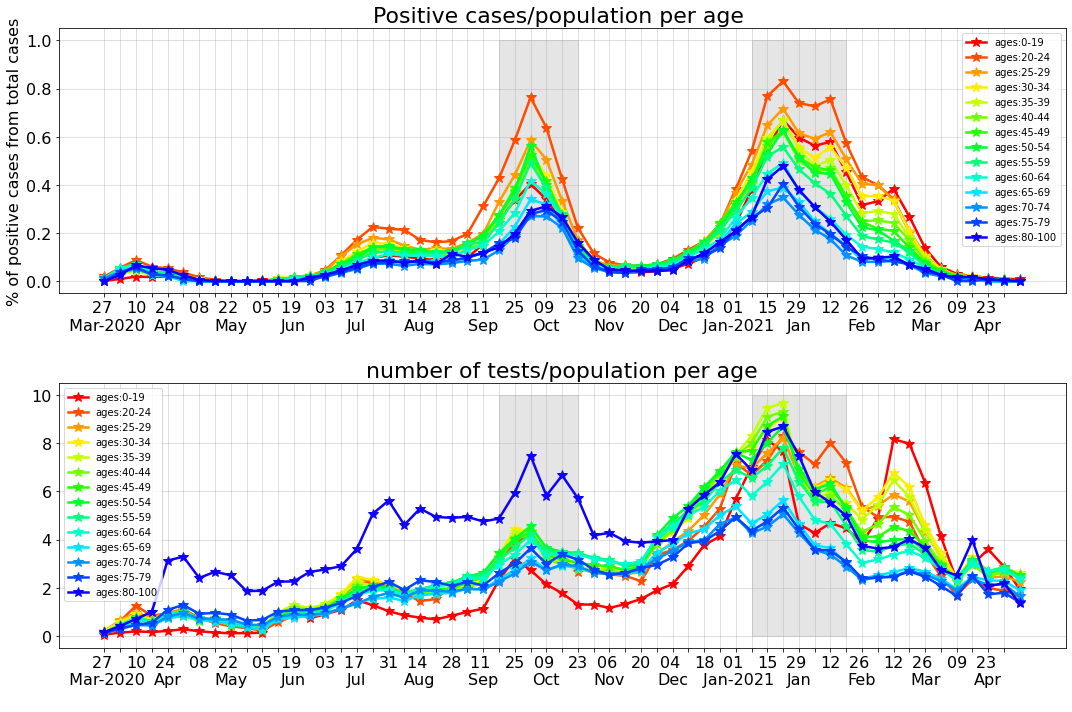

In [85]:
fig, ax = draw_per_population(age_gender_test_data, with_dead=False, with_new=False)
draw_lockdowns(fig, ax, max_y0=1, max_y1=10)
draw_new_x_axis(vaccinations_data, fig, ax)

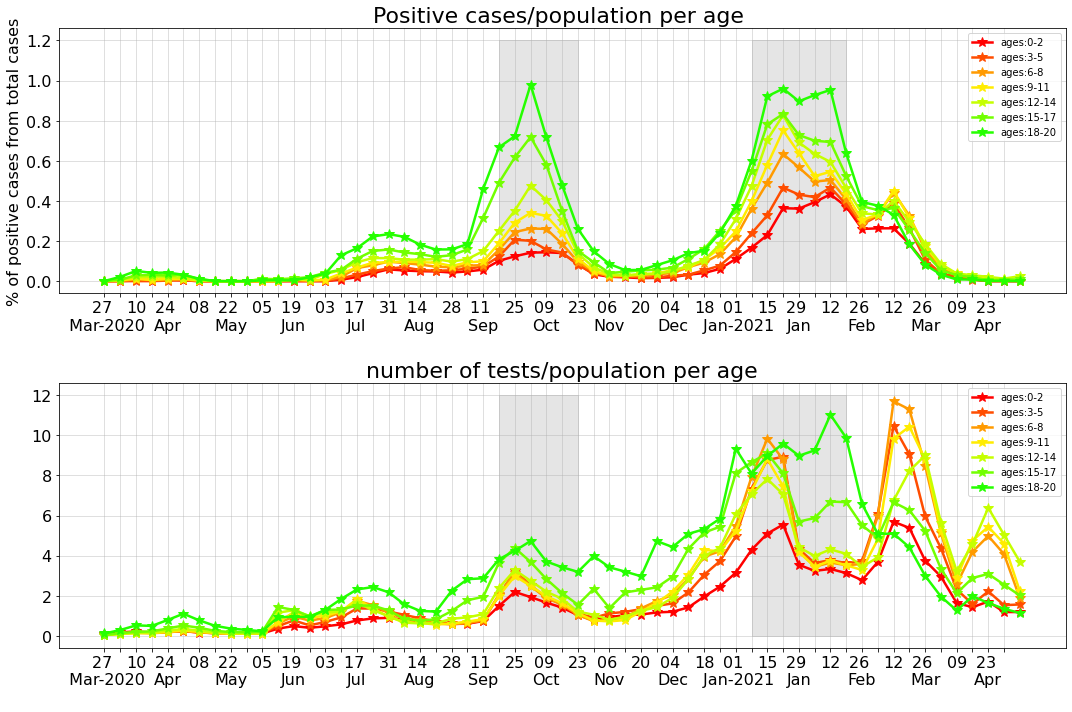

In [86]:
fig, ax = draw_per_population(young_test_data, with_dead=False, with_new=False)
draw_lockdowns(fig, ax, max_y0=1.2, max_y1=12)
draw_new_x_axis(vaccinations_data, fig, ax)

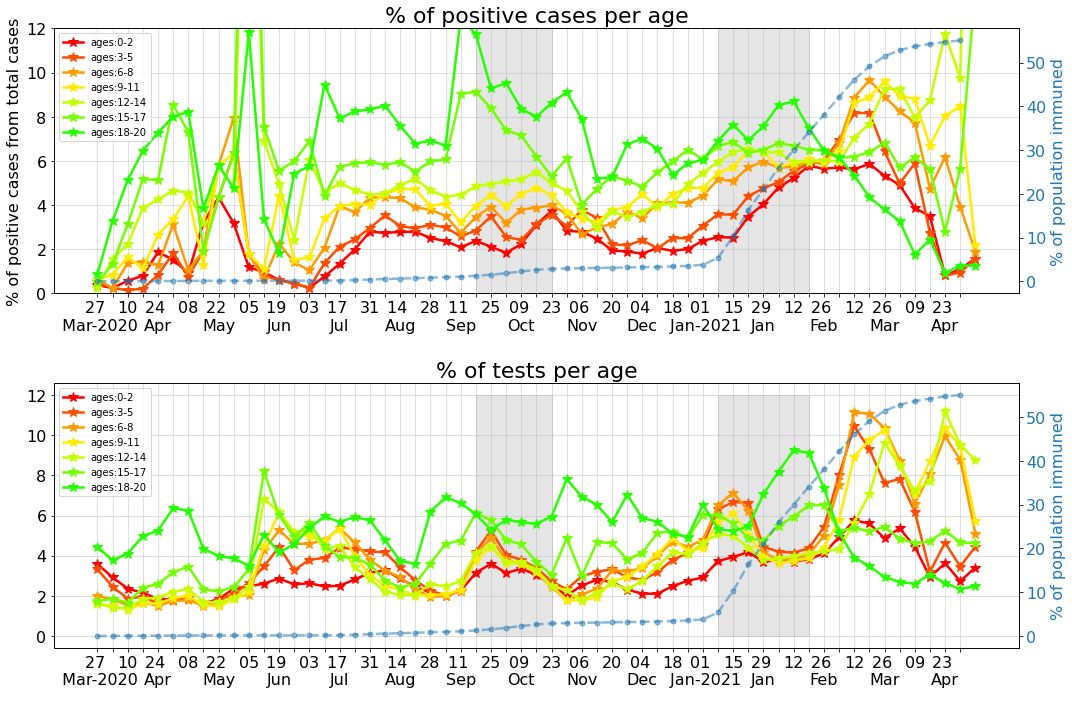

In [87]:
fig, ax = draw_per_total(young_test_data, test_data_agg_weeks, with_dead=False, with_new=False)
ax[0].set_ylim([0, 12])
draw_lockdowns(fig, ax, max_y0=45, max_y1=12)
draw_vaccinations_percentage(vaccinations_data, fig, ax, draw_total=True)
draw_new_x_axis(vaccinations_data, fig, ax)
fig.tight_layout()

## combine all ages into one table

In [88]:
age_gender_test_data_temp = age_gender_test_data[age_gender_test_data.max_age != 19]
all_testing_data = pd.concat([young_test_data, age_gender_test_data_temp]).drop(columns=['gender', 'weekly_deceased', 'weekly_newly_tested'])

In [89]:
young_data_tot = young_test_data[young_test_data.max_age != 20]
young_data_tot_to_15 = young_test_data[young_test_data.max_age <= 16]


In [90]:
young_data_tot = young_data_tot.groupby('weeks_from', as_index=False).agg({'max_age': 'last', 
                                        'percentage_age':'sum',
                                        'total_age_in_population': 'sum',
                                        'min_age':'first',
                                        'weekly_tests_num':'sum',
                                        'weekly_cases':'sum',
                                        'weekly_newly_tested':'sum'})
young_data_tot_to_15 = young_data_tot_to_15.groupby('weeks_from', as_index=False).agg({'max_age': 'last', 
                                        'percentage_age':'sum',
                                        'total_age_in_population': 'sum',
                                        'min_age':'first',
                                        'weekly_tests_num':'sum',
                                        'weekly_cases':'sum',
                                        'weekly_newly_tested':'sum'})

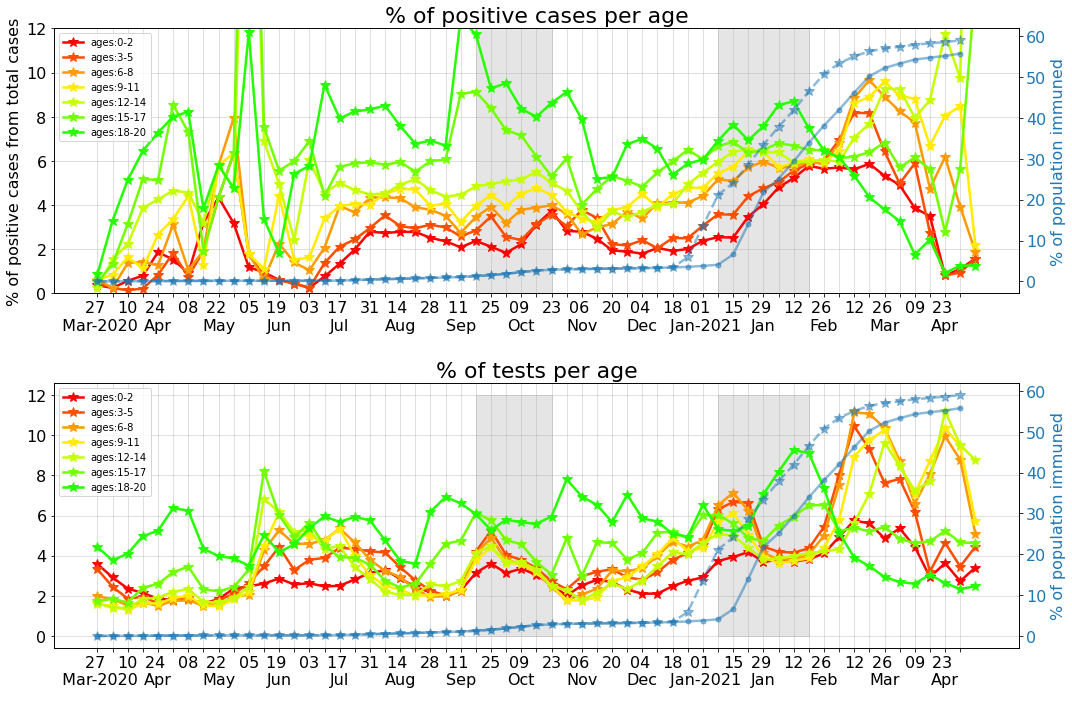

In [91]:
fig, ax = draw_per_total(young_test_data, test_data_agg_weeks, with_new=False, with_dead=False)
ax[0].set_ylim([0, 12])
draw_lockdowns(fig, ax, max_y0=12, max_y1=12)
draw_vaccinations_percentage(vaccinations_data, fig, ax)
draw_new_x_axis(vaccinations_data, fig, ax)

(20.0, 55.0)

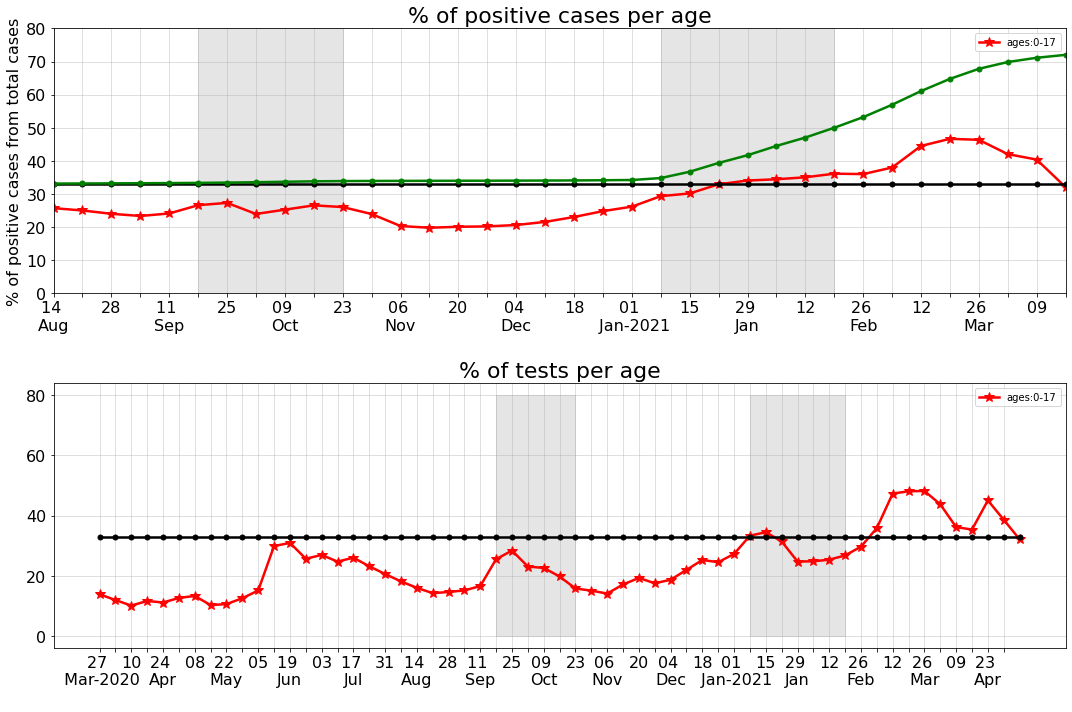

In [93]:
fig, ax = draw_per_total(young_data_tot, test_data_agg_weeks, with_new=False, with_dead=False)
percentage_0_17 = get_percentage_people_per_age_group(people_per_age, [(0, 17)])
ax[0].plot(young_data_tot['weeks_from'], np.zeros(shape=young_data_tot['weeks_from'].size) + percentage_0_17[(0, 17)], color='k', marker='.')
ax[1].plot(young_data_tot['weeks_from'], np.zeros(shape=young_data_tot['weeks_from'].size) + percentage_0_17[(0, 17)], color='k', marker='.')
ax[0].set_ylim([0, 50])
draw_lockdowns(fig, ax, max_y0=80, max_y1=80)
# add_important_information(fig, ax, max_y0=80, max_y1=80)
# draw_vaccinations_percentage(vaccinations_data, fig, ax, draw_total=True)
draw_new_x_axis(vaccinations_data, fig, ax)
infect_dec=np.zeros((19))
vacc_start_week = 0
infect_dec[:2 + vacc_start_week]=1-1
infect_dec[2+vacc_start_week:3+vacc_start_week]=1-0.43
infect_dec[3+vacc_start_week:4+vacc_start_week]=1-0.34
infect_dec[4+vacc_start_week:]=1-0.06
vaccinations_data_out= []
vacc_per_day = np.diff(vaccinations_data.iloc()[:,6])
for i in range(19):
    vaccinations_data_out.append(np.dot(np.expand_dims(infect_dec[:i+1][::-1],axis=0),vacc_per_day[38:38+i+1]))
vaccinations_data_out = np.array([0]*39 + list(vaccinations_data_out), dtype=object).astype(int).reshape(-1)    
total_immuned = vaccinations_data_out + vaccinations_data['accumulated_recoveries']
percentage_immuned = 100 * (total_immuned / total_population)
percentage_0_17_corrected = 100 * list(percentage_0_17.values())[0]*total_population/ (total_population*(100 - percentage_immuned))
ax[0].plot(young_data_tot['weeks_from'][:-1], percentage_0_17_corrected, marker='.', color='g')
ax[0].set_ylim([0, 80])
ax[0].set_xlim([20, 55])

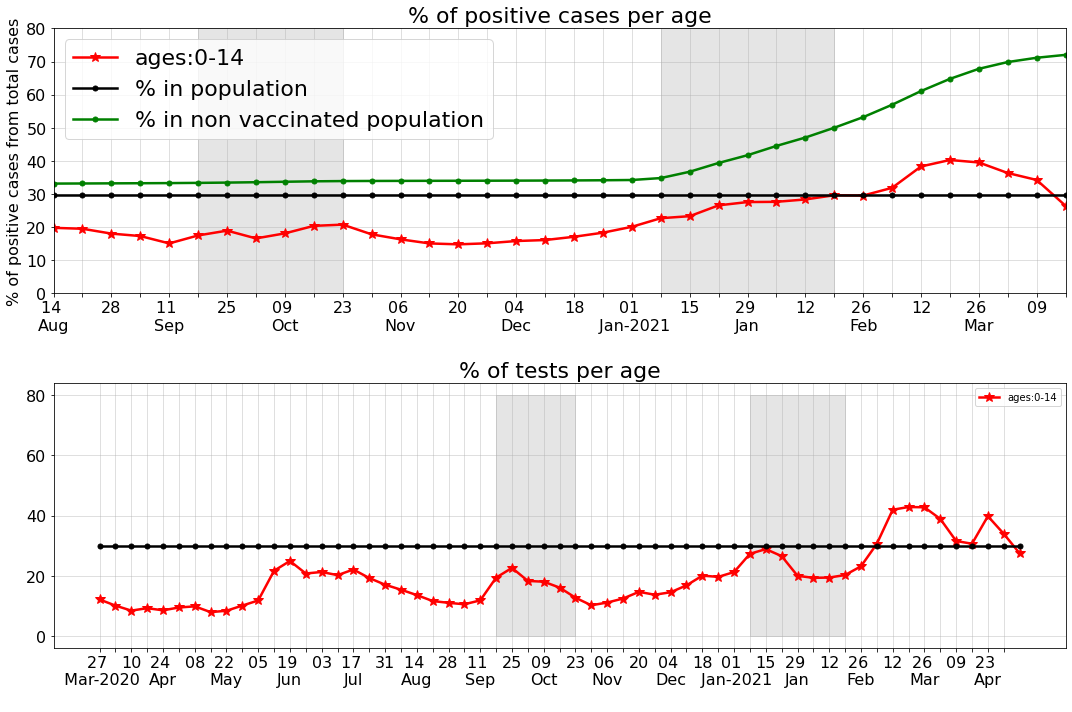

In [95]:
fig, ax = draw_per_total(young_data_tot_to_15, test_data_agg_weeks, with_new=False, with_dead=False)
percentage_0_15 = get_percentage_people_per_age_group(people_per_age, [(0, 15)])
ax[0].plot(young_data_tot_to_15['weeks_from'], np.zeros(shape=young_data_tot_to_15['weeks_from'].size) + percentage_0_15[(0, 15)], color='k', marker='.', label='% in population')
ax[1].plot(young_data_tot_to_15['weeks_from'], np.zeros(shape=young_data_tot_to_15['weeks_from'].size) + percentage_0_15[(0, 15)], color='k', marker='.', label='% in population')
ax[0].set_ylim([0, 50])
draw_lockdowns(fig, ax, max_y0=80, max_y1=80)
# add_important_information(fig, ax, max_y0=80, max_y1=80)
# draw_vaccinations_percentage(vaccinations_data, fig, ax, draw_total=True)
draw_new_x_axis(vaccinations_data, fig, ax)
infect_dec=np.zeros((19))
vacc_start_week = 0
infect_dec[:2 + vacc_start_week]=1-1
infect_dec[2+vacc_start_week:3+vacc_start_week]=1-0.43
infect_dec[3+vacc_start_week:4+vacc_start_week]=1-0.34
infect_dec[4+vacc_start_week:]=1-0.06
vaccinations_data_out= []
vacc_per_day = np.diff(vaccinations_data.iloc()[:,6])
for i in range(19):
    vaccinations_data_out.append(np.dot(np.expand_dims(infect_dec[:i+1][::-1],axis=0),vacc_per_day[38:38+i+1]))
vaccinations_data_out = np.array([0]*39 + list(vaccinations_data_out), dtype=object).astype(int).reshape(-1)    
total_immuned = vaccinations_data_out + vaccinations_data['accumulated_recoveries']
percentage_immuned = 100 * (total_immuned / total_population)
percentage_0_15_corrected = 100 * list(percentage_0_15.values())[0]*total_population/ (total_population*(100 - percentage_immuned))
ax[0].plot(young_data_tot_to_15['weeks_from'][:-1], percentage_0_17_corrected, marker='.', color='g', label='% in non vaccinated population')
ax[0].set_ylim([0, 80])
ax[0].set_xlim([20, 55])
ax[0].legend(fontsize=22)
fig.savefig('young_population_rise_in_positive_cases_explanantion.png', dpi=300, facecolor='white')

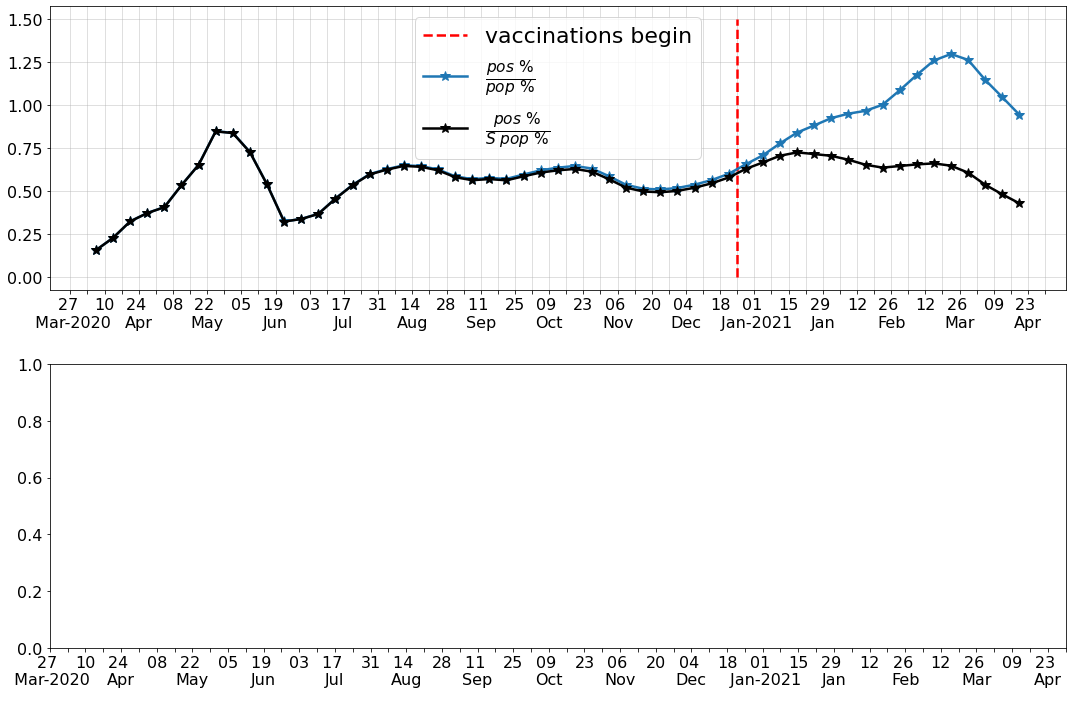

In [106]:
fig, ax = plt.subplots(2, 1)
percentage_15_positive = (100 * young_data_tot_to_15.weekly_cases / test_data_agg_weeks.weekly_cases)[:-1]
percentage_15_population = np.zeros(shape=young_data_tot_to_15['weeks_from'].size-1) + percentage_0_15[(0, 15)]
diff = (moving_average(percentage_15_positive, 4) / moving_average(percentage_15_population, 4))
diff_corrected = (moving_average(percentage_15_positive, 4) / moving_average(percentage_0_15_corrected, 4))
weeks_from_diff = moving_average(young_data_tot_to_15.weeks_from[:-1], 4)
ax[0].plot([39, 39], [0, 1.5], color='r', linestyle='--', label='vaccinations begin')
ax[0].plot(weeks_from_diff, diff, marker='*', label=r'$\frac{pos~\%}{pop~\%}$')
ax[0].plot(weeks_from_diff, diff_corrected, marker='*', color='k', label=r'$\frac{pos~\%}{S~pop~\%}$')
# draw_lockdowns(fig, ax, max_y0=1.5, max_y1=1.5)
# add_important_information(fig, ax, max_y0=1.5, max_y1=1.5)
# draw_vaccinations_percentage(vaccinations_data, fig, ax, draw_total=True)
draw_new_x_axis(vaccinations_data, fig, ax)
# ax[0].set_ylabel("% positive / % population")
ax[0].grid()
ax[0].legend(fontsize=22)
plt.savefig("normalized_young_population_positive_cases_per_population.png", dpi=300, facecolor='white')

In [ ]:
# fig, ax = plt.subplots(2, 1)
# ax[0].plot(vaccinations_data['weeks_from'], vaccinations_data.weeks_from)
# ax[0].grid()
# positions = vaccinations_data['weeks_from'].to_numpy()

# ax_new = plt.setp(ax[0], xticks=positions, xticklabels=ticklabels)
# # ax[0].set_xticks(positions, labels)A
# # draw_lockdowns(fig, ax, max_y0=800000, max_y1=1)
# # draw_vaccinations_percentage(vaccinations_data, fig, ax)

In [107]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


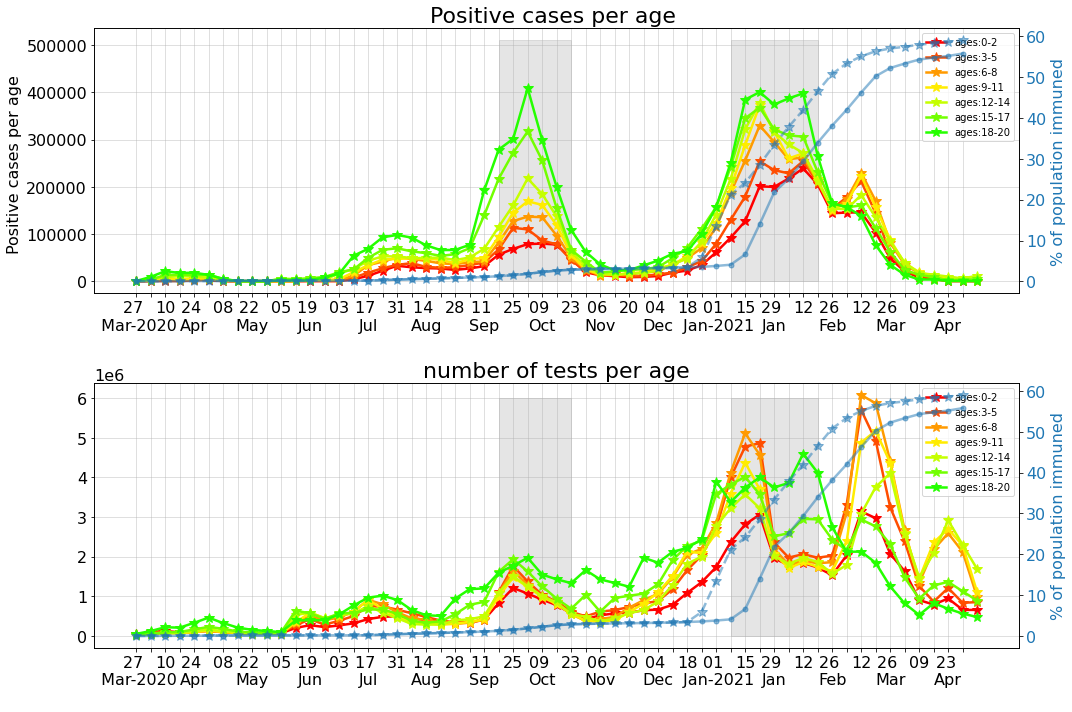

In [108]:
fig, ax = draw_absolute_numbers(young_test_data, with_dead=False)
draw_lockdowns(fig, ax, max_y0=510000, max_y1=6*10**6)
draw_vaccinations_percentage(vaccinations_data, fig, ax)
draw_new_x_axis(vaccinations_data, fig, ax)

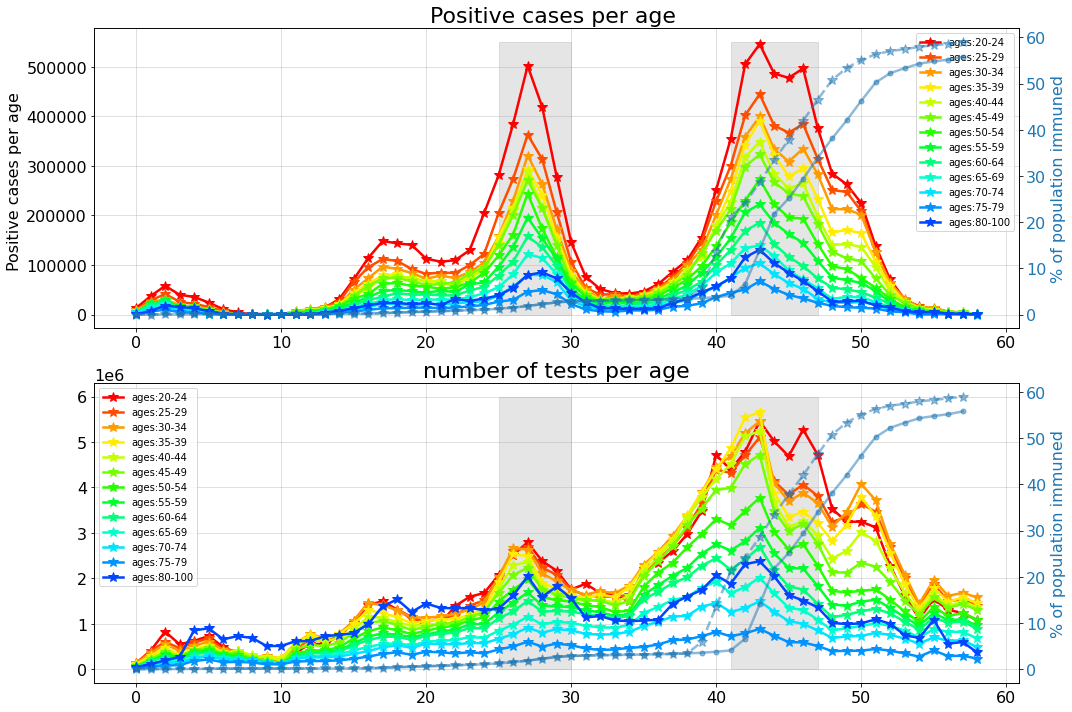

In [109]:
fig, ax = draw_absolute_numbers(age_gender_test_data_temp, with_dead=False)
draw_lockdowns(fig, ax, max_y0=550000, max_y1=6*10**6)
draw_vaccinations_percentage(vaccinations_data, fig, ax)
# draw_new_x_axis(vaccinations_data, fig, ax)

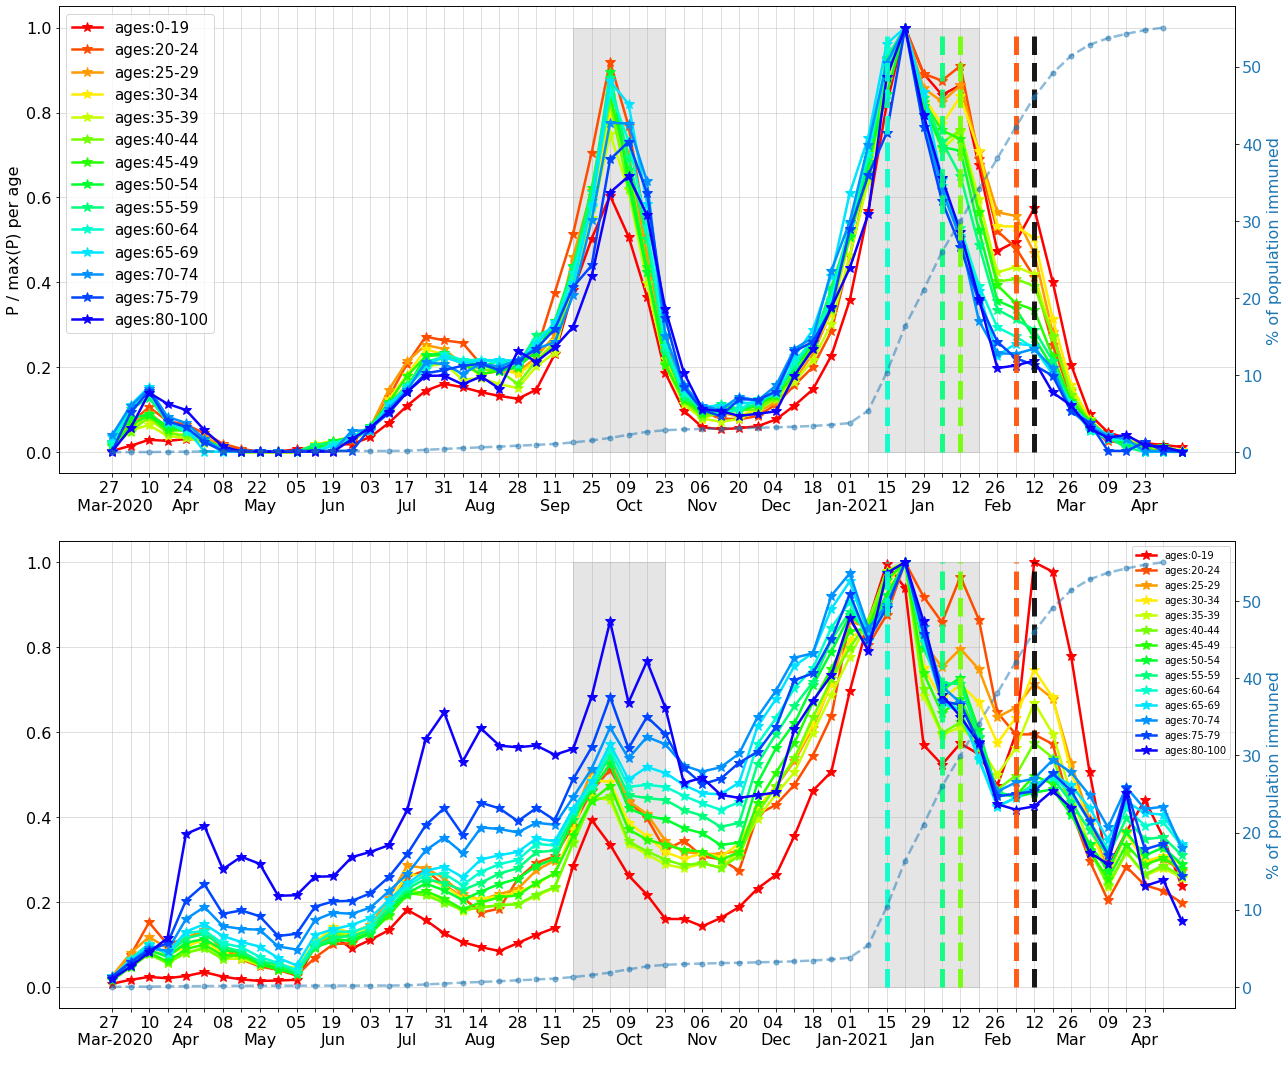

In [110]:
plt.rcParams["figure.figsize"] = (18,15)
fig, ax = draw_per_max(age_gender_test_data, with_dead=False, with_new=False)
draw_lockdowns(fig, ax, max_y0=1, max_y1=1)
add_important_information(fig, ax, max_y0=1, max_y1=1)
draw_vaccinations_percentage(vaccinations_data, fig, ax, draw_total=True)
draw_new_x_axis(vaccinations_data, fig, ax)
ax[0].legend(loc='upper left', fontsize=15)
fig.savefig('positive_cases_per_max_cases_all_ages.png', dpi=300, facecolor='white')

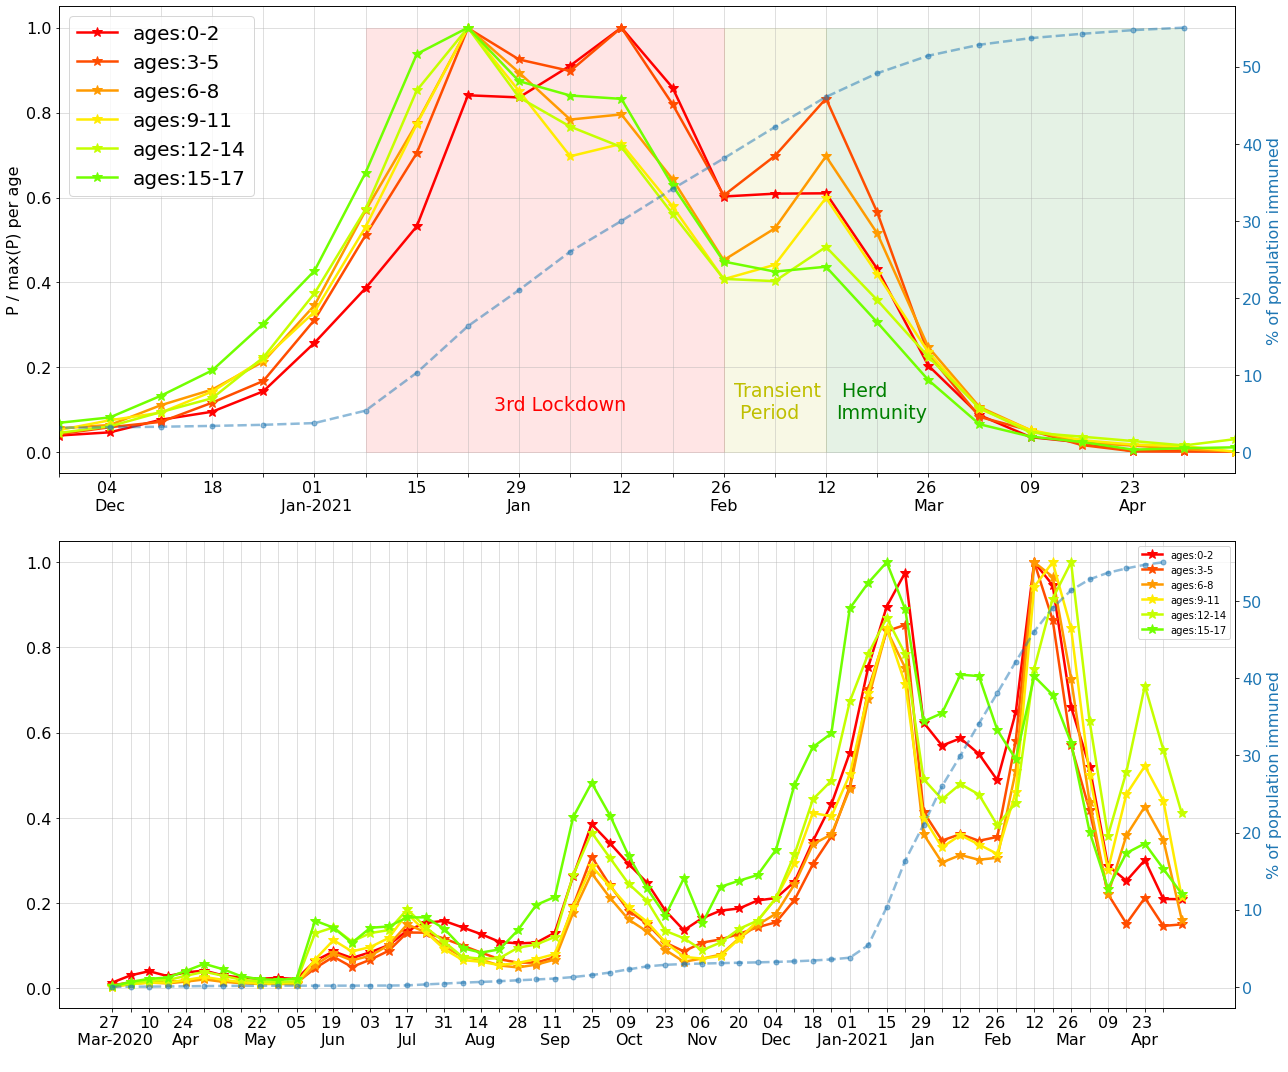

In [125]:
plt.rcParams["figure.figsize"] = (18,15)
young_no_18 = young_test_data[young_test_data.min_age != 18]
fig, ax = draw_per_max(young_no_18, with_dead=False, with_new=False)
ax[0].legend(fontsize=20, loc='upper left')
# draw_lockdowns(fig, ax, max_y0=1, max_y1=1)
draw_vaccinations_percentage(vaccinations_data, fig, ax, draw_total=True)
draw_new_x_axis(vaccinations_data, fig, ax)
rec = patches.Rectangle([50, 0], 7, 1.0, alpha=0.1, color='g')
ax[0].add_patch(rec)
rec = patches.Rectangle([48, 0], 2, 1.0, alpha=0.1, color='y')
ax[0].add_patch(rec)
rec = patches.Rectangle([41, 0], 7, 1.0, alpha=0.1, color='r')
ax[0].add_patch(rec)
ax[0].text(43.5, 0.1, "3rd Lockdown", color='r', fontsize=19)
ax[0].text(48.2, 0.08, "Transient \n Period", color='y', fontsize=19)
ax[0].text(50.2, 0.08, " Herd \nImmunity", color='g', fontsize=19)
# add_important_information(fig, ax, max_y0=100, max_y1=100)
ax[0].set_xlim([35, 58])

fig.savefig('positive_cases_per_max_cases_young_ages.png', dpi=300, facecolor='white')

In [112]:
agg_data_temp = all_testing_data.groupby(["weeks_from", 'min_age', 'max_age'], as_index = False).agg({'percentage_age': 'first', 
                                                                         'total_age_in_population': 'first', 
                                                                        'weeks_from': 'last', 
                                                                        'weekly_tests_num': 'sum', 
                                                                        'weekly_cases': 'sum'})
total_cases = np.sum(agg_data_temp.weekly_cases)

In [113]:
total_cases_temp = agg_data_temp.groupby("weeks_from", as_index=False).agg({'weekly_cases': 'sum', 'weeks_from': 'first'}).rename(columns={"weekly_cases":"total_cases"})

In [114]:
agg_data_temp = pd.merge(agg_data_temp, total_cases_temp, how="left", on="weeks_from")

In [115]:
agg_data_temp_2nd_lockdown = agg_data_temp[(agg_data_temp.weeks_from >= 12) & (agg_data_temp.weeks_from <=42)]

In [116]:
agg_data_temp_2nd_lockdown["weekly_cases_per_total_mean"] = 100 * agg_data_temp_2nd_lockdown["weekly_cases"]/agg_data_temp_2nd_lockdown["total_cases"]
agg_data_temp_2nd_lockdown["weekly_cases_per_total_std"] = 100 * agg_data_temp_2nd_lockdown["weekly_cases"]/agg_data_temp_2nd_lockdown["total_cases"]

<ipython-input-116-22440df48227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_data_temp_2nd_lockdown["weekly_cases_per_total_mean"] = 100 * agg_data_temp_2nd_lockdown["weekly_cases"]/agg_data_temp_2nd_lockdown["total_cases"]
<ipython-input-116-22440df48227>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_data_temp_2nd_lockdown["weekly_cases_per_total_std"] = 100 * agg_data_temp_2nd_lockdown["weekly_cases"]/agg_data_temp_2nd_lockdown["total_cases"]


In [117]:
agg_data_temp_per = agg_data_temp_2nd_lockdown.groupby(["min_age", "max_age"], as_index=False).agg({"min_age":"first",
                                                                                       "max_age":"first",
                                                                                       "percentage_age":"first",
                                                                                       "weekly_cases_per_total_mean": "mean", 
                                                                                      "weekly_cases_per_total_std": "std"})

In [118]:
# agg_data_temp['percentage_positive'] = np.round(100 * agg_data_temp.weekly_cases / total_cases, 3)

In [119]:
# agg_data_temp[['min_age', 'max_age', 'percentage_positive']]
# agg_data_temp_per


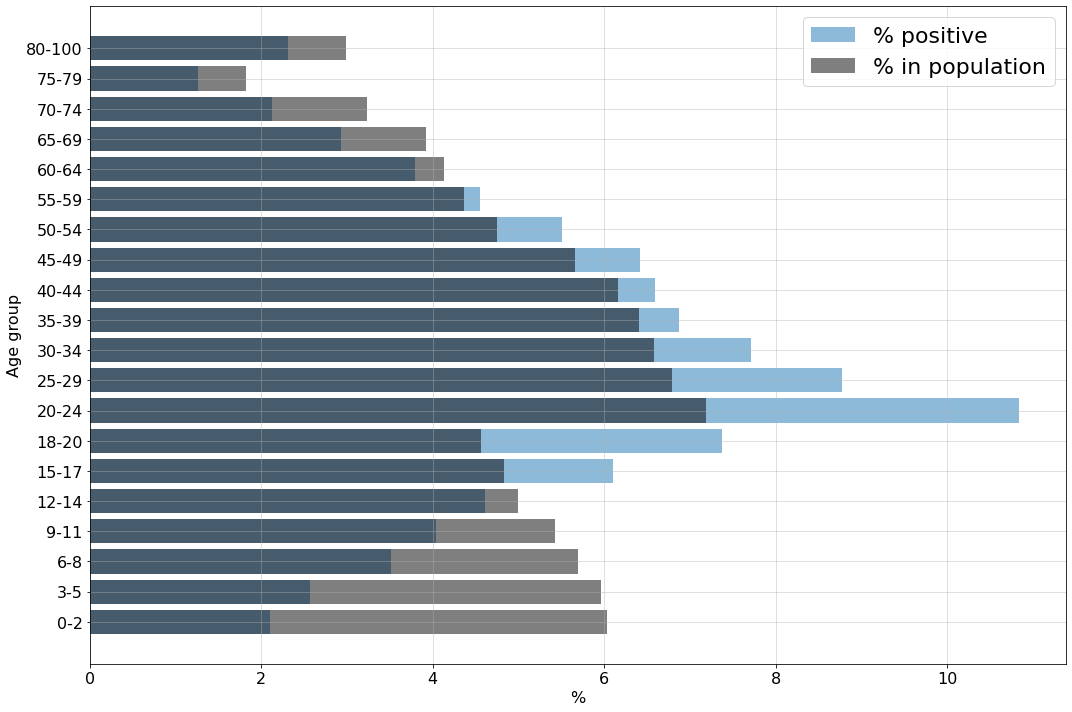

In [120]:
plt.rcParams["figure.figsize"] = (15,10)
height = agg_data_temp_per.weekly_cases_per_total_mean

bars = [f"{int(i)}-{int(j)}" for i,j in zip(agg_data_temp_per.min_age, agg_data_temp_per.max_age)]
height_population = agg_data_temp_per.percentage_age
y_pos = np.arange(len(bars))
plt.grid()
# Create horizontal bars
plt.barh(y_pos, height, alpha=0.5, label='% positive')
plt.barh(y_pos, height_population, color='k', alpha=0.5, label='% in population')

# Create names on the x-axis
plt.yticks(y_pos, bars)
plt.xlabel('%')
plt.ylabel('Age group')
plt.legend(fontsize=22)

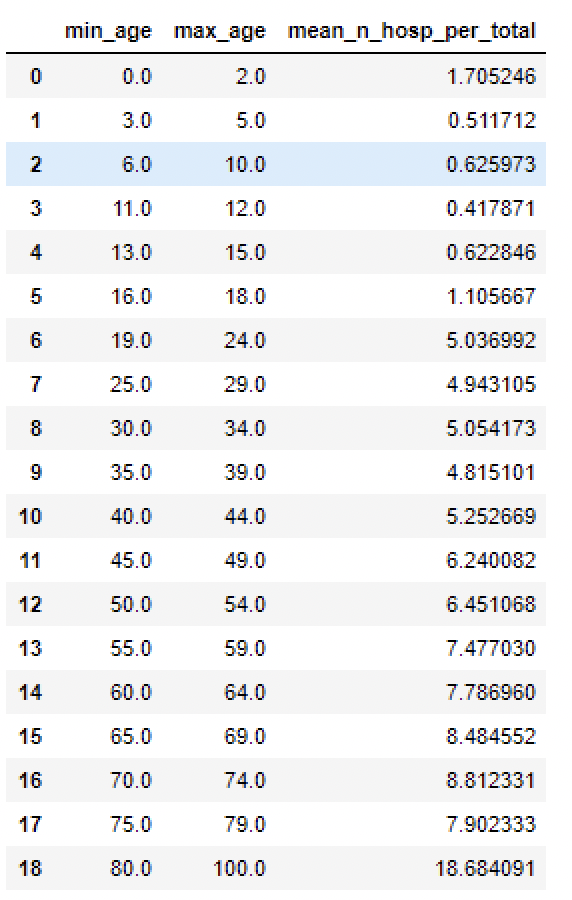

In [121]:
agg_data_temp_per[['min_age', 'max_age']]

min_age  max_age
0       0.0      2.0
1       3.0      5.0
2       6.0      8.0
3       9.0     11.0
4      12.0     14.0
5      15.0     17.0
6      18.0     20.0
7      20.0     24.0
8      25.0     29.0
9      30.0     34.0
10     35.0     39.0
11     40.0     44.0
12     45.0     49.0
13     50.0     54.0
14     55.0     59.0
15     60.0     64.0
16     65.0     69.0
17     70.0     74.0
18     75.0     79.0
19     80.0    100.0

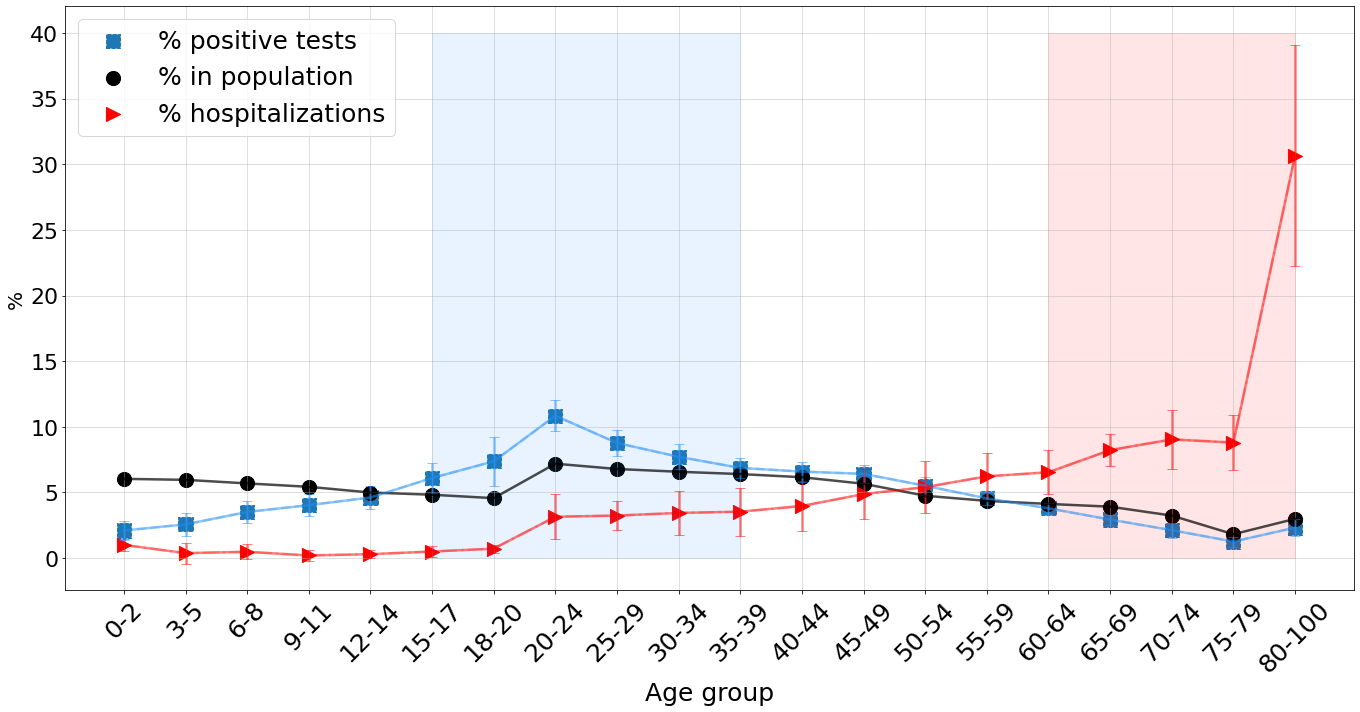

In [122]:
plt.rcParams["figure.figsize"] = (19,10)
# percentage hospitalizations are taken from confedential data   0.55
# percentage_hosp = np.array([1.705246, 0.511712, 0.625973, 0.55, 0.417871,0.622846,1.105667,5.036992,4.943105,5.054173
# ,4.815101,5.252669,6.240082,6.451068,7.477030,7.786960,8.484552,8.812331
# ,7.902333,18.68409])

percentage_hosp = np.array([1.003,
0.38,
0.48,
0.2,
0.3,
0.5,
0.722,
3.15,
3.24,
3.44,
3.537,
3.969,
4.877,
5.404,
6.228,
6.539,
8.225,
9.039,
8.799,
30.66])
std_hosp = np.array([0.49,
0.8,
0.58,
0.4,
0.3,
0.4,
0.3,
1.71,
1.09,
1.68,
1.833,
1.918,
1.908,
1.979,
1.755,
1.67,
1.212,
2.244,
2.099,
8.439])

x_pos_hosp = np.arange(len(percentage_hosp))
height = agg_data_temp_per.weekly_cases_per_total_mean
height_std = agg_data_temp_per.weekly_cases_per_total_std


x_bars = np.array([f"{int(i)}-{int(j)}" for i,j in zip(agg_data_temp_per.min_age, agg_data_temp_per.max_age)])
# y_pos = np.arange(0, 20, 3)
# y_bars = [f"{i}" for i in np.arange(0, 20, 3)]
height_population = agg_data_temp_per.percentage_age
x_pos = np.arange(0, len(bars))
fig, ax = plt.subplots(1, 1)
plt.grid()
# Create horizontal bars
ax.plot(x_pos, height, alpha=0.2, linestyle='--')
ax.scatter(x_pos, height, marker='s', label='% positive tests', linestyle='--', s=200)
ax.errorbar(x_pos, height, height_std, color='dodgerblue', alpha=0.5, capsize=5)

ax.plot(x_pos, height_population, color='k', alpha=0.7, linestyle='-')
ax.scatter(x_pos, height_population, color='k',  label='% in population', marker='o', s=200)

ax.plot(x_pos_hosp, percentage_hosp, color='r', alpha=0.2, linestyle='-.')
ax.scatter(x_pos_hosp, percentage_hosp, color='r',  label='% hospitalizations', marker='>', s=200)
ax.errorbar(x_pos_hosp, percentage_hosp, std_hosp, color='r', alpha=0.5, capsize=5)


rec = patches.Rectangle([len(percentage_hosp)-5, 0], 4, 40, alpha=0.1, color='r')
ax.add_patch(rec)
rec = patches.Rectangle([5, 0], 5, 40, alpha=0.1, color='dodgerblue')
ax.add_patch(rec)
# # Create names on the x-axis
ax.set_xticks(x_pos)
ax.set_xticklabels(x_bars, fontsize=25, rotation = 45)
ax.tick_params(axis='y', labelsize=22)
# ax.set_yticklabels(y_bars, fontsize=18)
ax.set_ylabel('%', fontsize=20)
ax.set_xlabel('Age group', fontsize=25)
ax.legend(fontsize=25)
plt.savefig("percentages_hosp_positive_population.png", dpi=300,  facecolor='white')


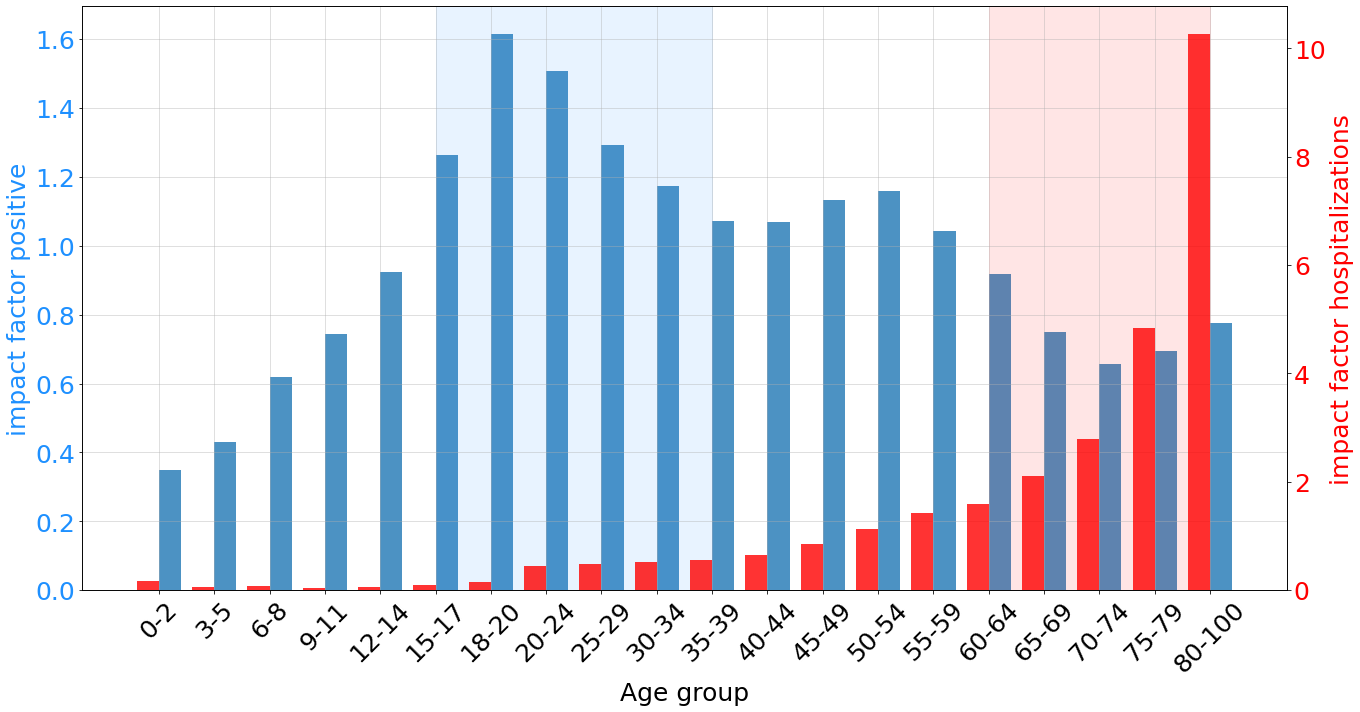

In [126]:
plt.rcParams["figure.figsize"] = (19,10)
# percentage hospitalizations are taken from confedential data   0.55
# percentage_hosp = np.array([1.705246, 0.511712, 0.625973, 0.55, 0.417871,0.622846,1.105667,5.036992,4.943105,5.054173
# ,4.815101,5.252669,6.240082,6.451068,7.477030,7.786960,8.484552,8.812331
# ,7.902333,18.68409])
percentage_hosp = np.array([1.003,
0.38,
0.48,
0.2,
0.3,
0.5,
0.722,
3.15,
3.24,
3.44,
3.537,
3.969,
4.877,
5.404,
6.228,
6.539,
8.225,
9.039,
8.799,
30.66])
x_pos_hosp = np.arange(len(percentage_hosp))
height = agg_data_temp_per.weekly_cases_per_total_mean

x_bars = np.array([f"{int(i)}-{int(j)}" for i,j in zip(agg_data_temp_per.min_age, agg_data_temp_per.max_age)])
# y_pos = np.arange(0, 20, 3)
# y_bars = [f"{i}" for i in np.arange(0, 20, 3)]
height_population = agg_data_temp_per.percentage_age
impact_hosp = percentage_hosp / height_population
impact_pos = height / height_population
x_pos = np.arange(len(bars))
fig, ax = plt.subplots(1, 1)
plt.grid()
# Create horizontal bars
ax.bar(x_pos + 0.2, impact_pos, alpha=0.8, width=0.4)
# ax.scatter(x_pos, impact_pos, marker='s', label='impact positive', linestyle='--', s=200)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('impact factor hospitalizations', color='r', fontsize=25)  # we already handled the x-label with ax1
ax2.bar(x_pos_hosp - 0.2, impact_hosp, color='r', alpha=0.8, width=0.4)
ax2.tick_params(axis='y', labelcolor='r', labelsize=25)
# ax.scatter(x_pos_hosp, impact_hosp, color='r',  label='impact hospitalizations', marker='>', s=200)

rec = patches.Rectangle([len(percentage_hosp)-5, 0], 4, 2, alpha=0.1, color='r')
ax.add_patch(rec)
rec = patches.Rectangle([5, 0], 5, 2, alpha=0.1, color='dodgerblue')
ax.add_patch(rec)
# # Create names on the x-axis
ax.set_xticks(x_pos)
ax.set_xticklabels(x_bars, fontsize=25, rotation=45)
ax.set_xticks(y_pos)
ax.tick_params(axis='y', labelcolor='dodgerblue', labelsize=25)
# ax.set_yticklabels(y_bars, fontsize=18)
ax.set_ylabel('impact factor positive', fontsize=25, color='dodgerblue')
ax.set_xlabel('Age group', fontsize=25)
# ax.legend(fontsize=25)
plt.savefig("impact_hosp_positive_population.png", dpi=300,  facecolor='white')


In [ ]:
impact_cases = agg_data_temp_per.weekly_cases_per_total_mean/agg_data_temp_per.percentage_age
bars = [f"{int(i)}-{int(j)}" for i,j in zip(agg_data_temp_per.min_age, agg_data_temp_per.max_age)]
y_pos = np.arange(len(bars))
plt.grid()
# Create horizontal bars
plt.barh(y_pos, impact_cases, alpha=0.5)

# Create names on the x-axis
plt.yticks(y_pos, bars)
plt.xlabel('% of positive cases / % in population')
plt.ylabel('Age group')

In [ ]:
impact_factor_dict = {a: i for a,i in zip(bars, impact_cases)}

In [ ]:
import pickle
with open('impact_factor_dict.pickle', 'wb') as handle:
    pickle.dump(impact_factor_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
geo_vacc_second_over_60 = geo_vacc_per_age['second_dose_60-69'] + geo_vacc_per_age['second_dose_70-79'] + geo_vacc_per_age['second_dose_80-89'] + geo_vacc_per_age['second_dose_90+']

In [ ]:
plt.plot(geo_vacc_per_age.weeks_from, geo_vacc_second_over_60)
plt.grid()

In [ ]:
geo_vacc_per_age.weeks_from

In [ ]:
age_gender_test_data

## draw cities per week

In [ ]:
def draw_towns_per_population(data_per_town):
    colors = get_cmap(n=200)
    fig, ax = plt.subplots(2, 1)
    for i, (t, df_t) in enumerate(data_per_town.groupby('town')):
        n_vacc = np.array(df_t['weekly_tests_num'])
        n_new_pos = np.array(df_t['weekly_cases'])
        n_weeks = np.array(df_t['weeks_from'])
        n_population = df_a['total_age_in_population'].mean()
        ax[0].plot(n_weeks, 100 * n_pos / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        ax[1].plot(n_weeks, 100 * n_tests / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_dead:
            n_dec = np.array(df_a['weekly_deceased'])
            ax[2].plot(n_weeks, 100 * n_dec / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
        if with_new:
            n_new = np.array(df_a['weekly_newly_tested'])
            ax[2].plot(n_weeks, 100 * n_new / n_population, color = colors[i], label=f'ages:{int(a[0])}-{int(a[1])}', marker='*')
            ax[2].set_title('number dead/population per age')
    
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    ax[0].set_title('Positive cases/population per age ')
    ax[1].set_title('number of tests/population per age')
    ax[0].set_ylabel('% of positive cases from total cases')
    if with_dead or with_new:
        ax[2].legend()
        ax[2].grid()
        ax[2].set_xlabel('Weeks from start of Covid')
    return fig, ax